# **The Human-Fire System: Socioeconomic Drivers of Wildfire Probability and Urban Population Smoke Exposure in East and Southern Africa**
## **A Satellite-Based Predictive Modelling Study (2018–2024)**

**Author:** Ujjwal Kumar Swain (ujjwalks.iirs@gmail.com)

> **Platform:** Google Earth Engine (Python API) + Google Colab  
> **Datasets:** MODIS MCD64A1; MODIS MCD12Q1; WorldPop; VIIRS NTL; CHIRPS; MODIS MOD13A3; Sentinel-5P TROPOMI; MODIS MOD14A1.
--

## Research Context and Motivation

Wildfires across East and Southern Africa are not purely ecological events - they sit at the intersection of human behaviour, land-use decisions, and atmospheric processes. In the miombo woodlands of Zambia and Tanzania, in the agricultural frontiers of Malawi and Mozambique, and across the savannas of Zimbabwe, fire is simultaneously a land management tool, an economic indicator, and an environmental hazard. Understanding *why* fire occurs where and when it does - and who bears the atmospheric consequences - is a central question for sustainable development in the region.

This notebook addresses that question through two tightly coupled analytical modules:

| Module | Question | Approach |
|--------|----------|----------|
| **A - Driver Model** | Which socioeconomic and climate variables explain inter-annual fire anomalies at landscape scale? | Random Forest Regression with SHAP explainability on a 1°×1° panel dataset |
| **B - Exposure Model** | Which East African cities carry the highest fire-smoke population exposure burden? | City-level Sentinel-5P atmospheric time series × WorldPop Population Exposure Index |

The two modules form a complete **human–fire–human feedback loop**: human land-use decisions drive fire, and fire-generated smoke returns to punish human populations - disproportionately in rapidly urbanising inland cities that sit downwind of fire-prone landscapes.

**Study area:** Zambia; Tanzania; Malawi; Mozambique; Zimbabwe (5 countries, ~3.2 million km²)

**Period:** 2018–2024 (7 years, aligned with Sentinel-5P operational availability)  

**Grid resolution:** 1°×1° (~100 km) for ML training | 7 km for S5P city extraction | 100 m for population weighting

## Section 1: Environment Setup and Library Imports

Before any analysis begins, it is important to be explicit about the computational environment. This notebook relies on a specific combination of geospatial, machine learning, and visualisation libraries. Installing and importing them in a controlled order prevents version conflicts - a common failure point in GEE-Python workflows running in Colab.

The key dependency groups are:

- **GEE Python API (`earthengine-api`) + `geemap`** - all satellite data extraction runs server-side on Google's infrastructure; Python acts as an orchestration layer, not a data mover
- **`scikit-learn` + `shap`** - the entire machine learning and explainability pipeline; SHAP specifically requires `TreeExplainer`, which works natively with scikit-learn Random Forest objects
- **`folium`** - interactive map rendering; chosen over Plotly or Kepler.gl because it produces a single self-contained HTML file with no server dependency, which is critical for sharing the deliverable
- **`geopandas` + `rasterio`** - vector/raster post-processing for any outputs that leave GEE into the local environment


In [2]:
!pip install -q geemap earthengine-api geopandas rasterio folium scikit-learn shap matplotlib seaborn contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.4 MB/s eta 0:00:00


In [3]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-ujjwalkumarswainiirs1')
print('GEE initialised successfully')

GEE initialised successfully


In [4]:
import warnings
import os
import time
import json as _json

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import folium
from folium.plugins import HeatMap, MiniMap, Fullscreen, MousePosition, MeasureControl
from IPython.display import HTML
import geemap

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import shap

from scipy import stats

warnings.filterwarnings('ignore')

for d in ['outputs/figures', 'outputs/maps', 'data/processed', 'data/raw']:
    os.makedirs(d, exist_ok=True)

print('Libraries imported- directory structure ready')

Libraries imported- directory structure ready


## Section 2: Study Area Definition and Global Configuration

All analysis parameters are centralised here rather than scattered across extraction cells. This matters for reproducibility: a single change to `AOI_COORDS` or `YEARS` propagates automatically to every downstream GEE call without hunting through 40 cells.

**Spatial grid design rationale:**  
The 1°×1° grid (~100 km × 80 km at 15°S) was chosen after testing 0.5° and 0.25° options. At 0.5°, the GEE compute quota for `reduceRegions` over 7 years was frequently exceeded. At 1°, each cell is large enough that MODIS 500m burned-area pixels fully tile the cell interior, the population density signal is stable, and the training dataset (~300 cells × 7 years ≈ 2,100 rows) is sufficient for Random Forest training with spatial cross-validation.

**Period design rationale:**  
2018–2024 was chosen because Sentinel-5P TROPOMI (the atmospheric sensor for Module B) became operationally reliable from mid-2018. Using a single consistent period across both modules ensures that fire driver patterns and city exposure patterns are temporally coherent - the same fires that the RF model attributes to socioeconomic drivers are the same fires whose smoke we track through urban air quality.

**Dry season definition (PEAK_MONTHS = July–October):**  
Across all five study countries, the dominant fire season falls between austral winter and early spring (July–October). This aligns with the dry phase of the Inter-Tropical Convergence Zone cycle and the post-senescence period when savanna and miombo grasses are most flammable. Filtering atmospheric data to this window isolates the fire-smoke signal from background aerosol noise during the wet season.


In [5]:
# Expanded bounding box to include Zimbabwe (25°E-40°E, 25°S-5°S)
# Zimbabwe: ~25°E-33°E, 15°S-22°S - fits within this box
AOI_COORDS     = [25, -25, 40, -5]   # [lon_min, lat_min, lon_max, lat_max]
aoi            = ee.Geometry.Rectangle(AOI_COORDS)

START_DATE     = '2018-01-01'
END_DATE       = '2024-12-31'
YEARS          = list(range(2018, 2025))    # 7 years
COUNTRIES_LIST = ['Zambia', 'Tanzania', 'Malawi', 'Mozambique', 'Zimbabwe']

MONTH_LABELS   = ['Jan','Feb','Mar','Apr','May','Jun',
                   'Jul','Aug','Sep','Oct','Nov','Dec']

# Country colours (5-country palette)
CLRS_C = dict(zip(COUNTRIES_LIST,
                  ['#e31a1c', '#fd8d3c', '#fecc5c', '#41ab5d', '#2c7bb6']))

# Dry / peak fire season: July – October
PEAK_MONTHS = [7, 8, 9, 10]

# GRID RESOLUTION for ML training
GRID_DEG = 1.0   # 1° × 1° ≈ 100 km at equator

print(f'Study countries : {", ".join(COUNTRIES_LIST)}')
print(f'Bounding box    : lon {AOI_COORDS[0]}°–{AOI_COORDS[2]}°E  '
      f'lat {AOI_COORDS[1]}°–{AOI_COORDS[3]}°S')
print(f'Temporal range  : {START_DATE} to {END_DATE}  ({len(YEARS)} years)')
print(f'Grid resolution : {GRID_DEG}° × {GRID_DEG}°')

Study countries : Zambia, Tanzania, Malawi, Mozambique, Zimbabwe
Bounding box    : lon 25°–40°E  lat -25°–-5°S
Temporal range  : 2018-01-01 to 2024-12-31  (7 years)
Grid resolution : 1.0° × 1.0°


## Section 3: Satellite Data Acquisition via Google Earth Engine

All primary datasets are extracted from the GEE data catalogue using the Python API. The extraction strategy follows a consistent pattern across all products:

1. **Filter by date and bounding box** - server-side filtering ensures only relevant tiles are loaded into GEE memory
2. **Apply band selection and scale factors** - MODIS products in particular require careful handling of scale factors (NDVI × 0.0001) and quality flags
3. **Use `reduceRegions` with appropriate reducer** - `ee.Reducer.mean()` for fractional/continuous variables, `ee.Reducer.sum()` for area-based quantities
4. **Export to Python as CSV** - `.getInfo()` pulls results into Pandas; results are saved to disk immediately so re-extraction is not necessary if the kernel crashes

One important design decision throughout: **`ee.Algorithms.If()` guards on every image collection** before computing means. African cloud cover and sensor gaps mean some month-cell combinations return empty collections. Without guards, GEE throws `Image.divide: 0 bands` errors that crash the entire extraction loop mid-run.

> **Compute time estimate:** Sections 3.1–3.5 together require approximately 35–45 minutes of GEE compute. Run them sequentially and let each cell complete before proceeding.


### 3.1. Annual Burned Fraction per Grid Cell - MODIS MCD64A1

**Why this target variable:**  
The burned fraction (proportion of each 1° cell that burned in a given year) is more analytically useful than raw burned area (km²) for two reasons. First, it normalises for cell size - cells that overlap coastlines or international borders are smaller than inland cells, so raw area comparisons are misleading. Second, a 0–1 fraction is a natural regression target that does not require heteroscedasticity corrections.

**The correct extraction approach - summing pixel areas, not taking binary maxima:**  
An earlier version of this extraction used `.max()` across monthly binary burn masks. At 1° resolution over African savanna, this collapsed every cell to `burned_fraction = 1.0` because *some* pixel burned *sometime* in virtually every cell. The correct approach sums the actual pixel areas (in km²) where `BurnDate > 0` across all months of the year, then divides by the total cell area. This produces genuine fractional values (0.0–0.69 observed range) with meaningful variance (σ = 0.167) that the downstream RF model can learn from.

**Dataset:** MODIS MCD64A1 Collection 6.1 - 500m monthly burned area product, `BurnDate` band (day-of-year when burned, 0 = unburned). Giglio et al. (2018) validated this product across sub-Saharan Africa with commission errors < 15%.


In [ ]:
# ---------------Build 1° × 1° grid as a GEE FeatureCollection ---------------------------------
# We enumerate grid cells in Python and push to GEE as a FeatureCollection.
# Each cell carries its centre coordinates as properties for later CSV export.

lon_min, lat_min, lon_max, lat_max = AOI_COORDS
grid_features = []
cell_id = 0

lon = lon_min
while lon < lon_max:
    lat = lat_min
    while lat < lat_max:
        cell = ee.Feature(
            ee.Geometry.Rectangle([lon, lat, lon + GRID_DEG, lat + GRID_DEG]),
            {
                'cell_id'   : cell_id,
                'lon_center': round(lon + GRID_DEG / 2, 2),
                'lat_center': round(lat + GRID_DEG / 2, 2),
            }
        )
        grid_features.append(cell)
        cell_id += 1
        lat += GRID_DEG
    lon += GRID_DEG

grid_fc = ee.FeatureCollection(grid_features)
n_cells = grid_fc.size().getInfo()
print(f'Grid cells created: {n_cells}  ({cell_id} cells, {len(YEARS)} years → {cell_id * len(YEARS)} panel observations)')

Grid cells created: 300  (300 cells, 7 years → 2100 panel observations)


In [ ]:
# ---------------SECTION 3.1. COMPLETE REWRITE ------------------------------------
# PROBLEM: Previous extraction used binary max → fraction = 1.0 everywhere
# FIX: Extract actual burned AREA (km²) per cell per year, then normalize
# by cell area → genuine fraction with real variance (proven approach from
# Project 1 which showed 22-679k km²/year variation across countries)

burned_collection = (
    ee.ImageCollection('MODIS/061/MCD64A1')
    .filterDate(START_DATE, END_DATE)
    .filterBounds(aoi)
    .select('BurnDate')
)

# Precompute pixel area image once
pixel_area_km2 = ee.Image.pixelArea().divide(1e6)

print('Re-extracting burned area per grid cell - ~8-12 minutes...')
print(f'({len(grid_features)} cells × {len(YEARS)} years)')

rows_burned = []

for yr in YEARS:
    # Annual burned AREA: sum pixel areas where BurnDate > 0 in any month
    # This uses the SAME logic as Project 1 which gave correct results
    annual_burned_km2 = (
        burned_collection
        .filter(ee.Filter.calendarRange(yr, yr, 'year'))
        .map(lambda img:
             img.gt(0)
             .multiply(pixel_area_km2)
             .rename('burned_km2')
        )
        .sum()    # sum across months → total km² burned that year
    )

    # Also compute cell total area for normalization
    cell_area_img = (
        ee.Image.constant(1)
        .multiply(pixel_area_km2)
        .rename('cell_area_km2')
    )

    combined = annual_burned_km2.addBands(cell_area_img)

    result = combined.reduceRegions(
        collection = grid_fc,
        reducer    = ee.Reducer.sum(),   # SUM not mean - we want total km²
        scale      = 500,
        crs        = 'EPSG:4326',
    )

    records = result.getInfo()['features']
    for rec in records:
        p = rec['properties']
        burned_km2   = p.get('burned_km2', 0) or 0
        cell_area    = p.get('cell_area_km2', 1) or 1
        # True fraction: what proportion of the cell actually burned this year
        true_fraction = min(burned_km2 / cell_area, 1.0) if cell_area > 0 else 0

        rows_burned.append({
            'year'            : yr,
            'cell_id'         : p.get('cell_id'),
            'lon_center'      : p.get('lon_center'),
            'lat_center'      : p.get('lat_center'),
            'burned_km2'      : round(burned_km2, 2),
            'cell_area_km2'   : round(cell_area, 2),
            'burned_fraction' : round(true_fraction, 6),
        })

    # Quick sanity check per year
    yr_fracs = [r['burned_fraction'] for r in rows_burned if r['year'] == yr]
    print(f'  {yr}: {len(records)} cells | '
          f'burned_fraction range: {min(yr_fracs):.3f} – {max(yr_fracs):.3f} | '
          f'mean: {np.mean(yr_fracs):.3f}')

df_burned_grid = pd.DataFrame(rows_burned)
df_burned_grid.to_csv('data/processed/burned_fraction_grid_2018_2024.csv', index=False)

print(f'\n=== EXTRACTION SANITY CHECK ===')
print(f'Total rows: {len(df_burned_grid)}')
print(f'burned_fraction std: {df_burned_grid["burned_fraction"].std():.4f}')
print(f'                     (must be > 0.05 to proceed)')
print(f'\nDistribution:')
print(df_burned_grid['burned_fraction'].describe().round(4))

Re-extracting burned area per grid cell — ~8-12 minutes...
(300 cells × 7 years)
  2018: 300 cells | burned_fraction range: 0.000 – 0.634 | mean: 0.172
  2019: 300 cells | burned_fraction range: 0.000 – 0.678 | mean: 0.175
  2020: 300 cells | burned_fraction range: 0.000 – 0.686 | mean: 0.157
  2021: 300 cells | burned_fraction range: 0.000 – 0.675 | mean: 0.164
  2022: 300 cells | burned_fraction range: 0.000 – 0.669 | mean: 0.178
  2023: 300 cells | burned_fraction range: 0.000 – 0.623 | mean: 0.158
  2024: 300 cells | burned_fraction range: 0.000 – 0.663 | mean: 0.155

=== EXTRACTION SANITY CHECK ===
Total rows: 2100
burned_fraction std: 0.1673
                     (must be > 0.05 to proceed)

Distribution:
count    2100.0000
mean        0.1656
std         0.1673
min         0.0000
25%         0.0191
50%         0.1090
75%         0.2785
max         0.6864
Name: burned_fraction, dtype: float64


### 3.2. Socioeconomic and Environmental Feature Extraction

The predictor variables for Module A are chosen to represent three distinct classes of fire driver:

| Class | Variables | Mechanistic Pathway |
|-------|-----------|-------------------|
| **Human pressure** | Log population density, Log nighttime lights | Higher population → more ignitions; higher NTL → more fire suppression capacity |
| **Land cover / fuel type** | Cropland %, Forest %, Savanna % | Cropland fires are intentional (clearing); savanna is the primary pyrogenic fuel; forest is fire-resistant |
| **Climate / fuel condition** | Dry-season NDVI, Annual rainfall | NDVI indexes fuel greenness/dryness; rainfall controls moisture constraint on ignition |

**Log-transforming population density and NTL:**  
Both variables are severely right-skewed in this region - a handful of cells containing Dar es Salaam or Lusaka have orders-of-magnitude higher values than rural cells. Log-transformation compresses the tails, prevents these outlier cells from dominating Random Forest splits, and linearises the relationship with fire probability.

**WorldPop cap at 2020:**  
The WorldPop 100m GP product is available through 2020. For 2021–2024 we reuse the 2020 grid - a defensible choice given that population redistribution within 1° cells changes slowly relative to the fire dynamics we are modelling. An alternative would be to project 2020 populations using UN growth rates, but the added complexity is not justified at this spatial resolution.

**ERA5-Land in place of CHIRPS:**  
The CHIRPS monthly collection (`UCSB-CHG/CHIRPS/MONTHLY`) was unavailable in GEE at the time of this analysis. ERA5-Land monthly total precipitation (`total_precipitation_sum`, units: m/month) was used as a substitute. ERA5-Land has 9km resolution - coarser than CHIRPS (5km) but more than adequate for a 1° analysis grid.


In [ ]:
# ---------------WorldPop population density & VIIRS Nighttime Lights ----------------------
# FIX: WorldPop GP/100m/pop is only available through 2020.
# For 2021-2024 we reuse the 2020 population grid (reasonable for a 4-year window).
# We also remove the ISO3 country filter and use filterBounds(aoi) instead -
# the country filter was causing empty collections for years with incomplete coverage.

print('Extracting population density and nighttime lights - ~5-7 minutes...')

rows_socio = []

# Preload WorldPop: use latest available year per requested year
WORLDPOP_MAX_YEAR = 2020

def get_worldpop(yr):
    """Return WorldPop mosaic for yr, capped at WORLDPOP_MAX_YEAR."""
    use_yr = min(yr, WORLDPOP_MAX_YEAR)
    return (
        ee.ImageCollection('WorldPop/GP/100m/pop')
        .filter(ee.Filter.eq('year', use_yr))
        .filterBounds(aoi)
        .mosaic()
        .unmask(0)          # replace masked pixels with 0 (water/no-data)
        .rename('population')
    )

for yr in YEARS:
    # Population density
    pop_img      = get_worldpop(yr)
    cell_area_km2 = ee.Image.pixelArea().divide(1e6)

    # Guard: only divide where population image actually has values
    pop_density  = (
        pop_img
        .divide(cell_area_km2)
        .rename('pop_density')
        .unmask(0)
    )

    # VIIRS DNB: annual mean of monthly composites
    ntl_col = (
        ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
        .filterDate(f'{yr}-01-01', f'{yr}-12-31')
        .filterBounds(aoi)
        .select('avg_rad')
    )
    # Handle years where NTL collection might be empty
    ntl_img = ee.Algorithms.If(
        ntl_col.size().gt(0),
        ntl_col.mean().rename('ntl_mean').unmask(0),
        ee.Image.constant(0).rename('ntl_mean').clip(aoi)
    )
    ntl_img = ee.Image(ntl_img)

    combined = pop_density.addBands(ntl_img)

    result = combined.reduceRegions(
        collection = grid_fc,
        reducer    = ee.Reducer.mean(),
        scale      = 1000,
        crs        = 'EPSG:4326',
    )

    for rec in result.getInfo()['features']:
        p = rec['properties']
        rows_socio.append({
            'year'       : yr,
            'cell_id'    : p.get('cell_id'),
            'pop_density': p.get('pop_density', 0) or 0,
            'ntl_mean'   : p.get('ntl_mean', 0) or 0,
        })

    print(f'  {yr}: socioeconomic features done')

df_socio = pd.DataFrame(rows_socio)
df_socio.to_csv('data/processed/socio_grid_2018_2024.csv', index=False)
print(f'Socioeconomic data saved: {len(df_socio)} rows')

Extracting population density and nighttime lights — ~5-7 minutes...
  2018: socioeconomic features done
  2019: socioeconomic features done
  2020: socioeconomic features done
  2021: socioeconomic features done
  2022: socioeconomic features done
  2023: socioeconomic features done
  2024: socioeconomic features done
Socioeconomic data saved: 2100 rows


In [ ]:
# ---------------Land cover (cropland %, forest %) from MODIS MCD12Q1 IGBP ---------------------
# IGBP cropland classes: 12 (Cropland), 14 (Cropland/Vegetation Mosaic)
# IGBP forest classes : 1-5 (Evergreen NL/BL, Deciduous NL/BL, Mixed Forest)
# We compute the fraction of each 1° cell covered by each class.
# Using a single representative year per window (one MCD12Q1 per year).

print('Extracting land cover fractions - ~4-5 minutes...')

CROPLAND_CLASSES = [12, 14]          # IGBP cropland types
FOREST_CLASSES   = [1, 2, 3, 4, 5]  # IGBP forest types
SAVANNA_CLASSES  = [8, 9]            # Woody savanna + Savanna (high fire)

rows_lc = []

for yr in YEARS:
    lc_img = (
        ee.ImageCollection('MODIS/061/MCD12Q1')
        .filterDate(f'{yr}-01-01', f'{yr}-12-31')
        .first()
        .select('LC_Type1')
    )

    cropland_mask = lc_img.remap(
        CROPLAND_CLASSES, [1] * len(CROPLAND_CLASSES), 0
    ).rename('cropland')
    forest_mask = lc_img.remap(
        FOREST_CLASSES, [1] * len(FOREST_CLASSES), 0
    ).rename('forest')
    savanna_mask = lc_img.remap(
        SAVANNA_CLASSES, [1] * len(SAVANNA_CLASSES), 0
    ).rename('savanna')

    lc_combined = cropland_mask.addBands(forest_mask).addBands(savanna_mask)

    result = lc_combined.reduceRegions(
        collection = grid_fc,
        reducer    = ee.Reducer.mean(),
        scale      = 500,
        crs        = 'EPSG:4326',
    )

    for rec in result.getInfo()['features']:
        p = rec['properties']
        rows_lc.append({
            'year'        : yr,
            'cell_id'     : p.get('cell_id'),
            'cropland_pct': (p.get('cropland', 0) or 0) * 100,
            'forest_pct'  : (p.get('forest', 0) or 0) * 100,
            'savanna_pct' : (p.get('savanna', 0) or 0) * 100,
        })

    print(f'  {yr}: land cover done')

df_lc = pd.DataFrame(rows_lc)
df_lc.to_csv('data/processed/landcover_grid_2018_2024.csv', index=False)
print(f'Land cover data saved: {len(df_lc)} rows')

Extracting land cover fractions — ~4-5 minutes...
  2018: land cover done
  2019: land cover done
  2020: land cover done
  2021: land cover done
  2022: land cover done
  2023: land cover done
  2024: land cover done
Land cover data saved: 2100 rows


In [ ]:
# ---------------NDVI (dry season) & ERA5-Land annual rainfall ----------------------------------
# FIX 1: CHIRPS collection ID is unavailable - replaced with ERA5-Land monthly
#         total_precipitation_sum (units: metres/month → convert to mm)
# FIX 2: MOD13A3 NDVI band name verified as '1_km_monthly_NDVI' (no leading _)
#         Using .first() to inspect available bands and selecting safely.

print('Extracting NDVI and rainfall - ~4-5 minutes...')

rows_env = []

# Verify NDVI band name once before the loop
ndvi_test = (
    ee.ImageCollection('MODIS/061/MOD13A3')
    .filterDate('2020-05-01', '2020-05-31')
    .first()
)
ndvi_bands = ndvi_test.bandNames().getInfo()
print(f'  MOD13A3 available bands: {ndvi_bands}')

# Pick whichever NDVI band name actually exists
NDVI_BAND = next(
    (b for b in ndvi_bands if 'NDVI' in b.upper()),
    ndvi_bands[0]  # fallback to first band
)
print(f'  Using NDVI band: {NDVI_BAND}')

for yr in YEARS:
    # ------ Dry-season NDVI (May–Oct) -----------------------------------------
    ndvi_col = (
        ee.ImageCollection('MODIS/061/MOD13A3')
        .filterDate(f'{yr}-05-01', f'{yr}-10-31')
        .filterBounds(aoi)
        .select(NDVI_BAND)
    )
    ndvi_dry = ee.Algorithms.If(
        ndvi_col.size().gt(0),
        ndvi_col.mean().multiply(0.0001).rename('ndvi_dry').unmask(0),
        ee.Image.constant(0).rename('ndvi_dry').clip(aoi)
    )
    ndvi_dry = ee.Image(ndvi_dry)

    # ------ ERA5-Land annual total precipitation ---------------------------------
    # Band: total_precipitation_sum (m/month) → sum 12 months → multiply 1000 → mm/year
    era5_col = (
        ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
        .filterDate(f'{yr}-01-01', f'{yr}-12-31')
        .filterBounds(aoi)
        .select('total_precipitation_sum')
    )
    rainfall_annual = ee.Algorithms.If(
        era5_col.size().gt(0),
        era5_col.sum().multiply(1000).rename('rainfall_mm').unmask(0),
        ee.Image.constant(0).rename('rainfall_mm').clip(aoi)
    )
    rainfall_annual = ee.Image(rainfall_annual)

    env_combined = ndvi_dry.addBands(rainfall_annual)

    result = env_combined.reduceRegions(
        collection = grid_fc,
        reducer    = ee.Reducer.mean(),
        scale      = 5000,
        crs        = 'EPSG:4326',
    )

    for rec in result.getInfo()['features']:
        p = rec['properties']
        rows_env.append({
            'year'       : yr,
            'cell_id'    : p.get('cell_id'),
            'ndvi_dry'   : p.get('ndvi_dry', np.nan),
            'rainfall_mm': p.get('rainfall_mm', 0) or 0,
        })

    print(f'  {yr}: NDVI and rainfall done')

df_env = pd.DataFrame(rows_env)
df_env.to_csv('data/processed/environment_grid_2018_2024.csv', index=False)
print(f'Environmental data saved: {len(df_env)} rows')

Extracting NDVI and rainfall — ~4-5 minutes...
  MOD13A3 available bands: ['NDVI', 'EVI', 'DetailedQA', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07', 'ViewZenith', 'SolarZenith', 'RelativeAzimuth', 'SummaryQA']
  Using NDVI band: NDVI
  2018: NDVI and rainfall done
  2019: NDVI and rainfall done
  2020: NDVI and rainfall done
  2021: NDVI and rainfall done
  2022: NDVI and rainfall done
  2023: NDVI and rainfall done
  2024: NDVI and rainfall done
Environmental data saved: 2100 rows


### 3.3. City-Level Atmospheric and Active Fire Extraction - Sentinel-5P TROPOMI + MODIS MOD14A1

**Why Sentinel-5P Absorbing Aerosol Index (AAI) as the smoke proxy:**  
AAI is the UV-derived index of absorbing (dark) aerosols - predominantly black carbon and brown carbon from biomass burning. Unlike AOD (aerosol optical depth), AAI is retrievable over bright surfaces including the arid zones common in southern Africa, and is less sensitive to cloud contamination in the UV than in the visible spectrum. For fire-smoke attribution, AAI is the most direct satellite-measurable quantity.

**250 km buffer rationale:**  
A 250 km radius around each city was chosen to capture the regional smoke environment - the atmospheric footprint from which fire smoke can travel and accumulate over a city within a 24–72 hour transport window, which is the typical advection timescale in the low-level jet systems that dominate smoke transport in East Africa during the dry season. A smaller buffer (e.g., 50 km) would capture only local fires and miss the dominant regional signal; a larger buffer (e.g., 500 km) would average across multiple climatically distinct zones.

**Population Exposure Index (PEI) formula:**  
> PEI = Σ max(AAI_anomaly, 0) × urban_population / 10⁶

The anomaly form (deviation from city-specific monthly climatology) is critical. Raw AAI values differ systematically between coastal cities (lower background aerosol) and inland cities (higher dust + smoke baseline). Using anomalies removes this climatological bias and ensures the PEI captures *excess* smoke exposure above the local normal - which is the policy-relevant quantity.


In [ ]:
# ---------------City definitions: 15 major cities across 5 countries-------------------------
# Coordinates verified against GEE geometry (WGS84)
CITIES = [
    # Zambia
    {'city': 'Lusaka',       'country': 'Zambia',      'lon':  28.28, 'lat': -15.42},
    {'city': 'Ndola',        'country': 'Zambia',      'lon':  28.64, 'lat': -12.97},
    {'city': 'Kitwe',        'country': 'Zambia',      'lon':  28.21, 'lat': -12.82},
    # Tanzania
    {'city': 'Dar es Salaam','country': 'Tanzania',    'lon':  39.29, 'lat':  -6.79},
    {'city': 'Mwanza',       'country': 'Tanzania',    'lon':  32.90, 'lat':  -2.52},
    {'city': 'Arusha',       'country': 'Tanzania',    'lon':  36.68, 'lat':  -3.39},
    # Malawi
    {'city': 'Lilongwe',     'country': 'Malawi',      'lon':  33.78, 'lat': -13.97},
    {'city': 'Blantyre',     'country': 'Malawi',      'lon':  35.00, 'lat': -15.79},
    # Mozambique
    {'city': 'Maputo',       'country': 'Mozambique',  'lon':  32.59, 'lat': -25.96},
    {'city': 'Beira',        'country': 'Mozambique',  'lon':  34.84, 'lat': -19.84},
    {'city': 'Nampula',      'country': 'Mozambique',  'lon':  39.26, 'lat': -15.12},
    # Zimbabwe
    {'city': 'Harare',       'country': 'Zimbabwe',    'lon':  31.05, 'lat': -17.83},
    {'city': 'Bulawayo',     'country': 'Zimbabwe',    'lon':  28.58, 'lat': -20.15},
    {'city': 'Mutare',       'country': 'Zimbabwe',    'lon':  32.67, 'lat': -18.97},
    {'city': 'Gweru',        'country': 'Zimbabwe',    'lon':  29.82, 'lat': -19.46},
]

df_cities_meta = pd.DataFrame(CITIES)
print(f'Cities defined: {len(CITIES)}')
print(df_cities_meta.to_string(index=False))

Cities defined: 15
         city    country   lon    lat
       Lusaka     Zambia 28.28 -15.42
        Ndola     Zambia 28.64 -12.97
        Kitwe     Zambia 28.21 -12.82
Dar es Salaam   Tanzania 39.29  -6.79
       Mwanza   Tanzania 32.90  -2.52
       Arusha   Tanzania 36.68  -3.39
     Lilongwe     Malawi 33.78 -13.97
     Blantyre     Malawi 35.00 -15.79
       Maputo Mozambique 32.59 -25.96
        Beira Mozambique 34.84 -19.84
      Nampula Mozambique 39.26 -15.12
       Harare   Zimbabwe 31.05 -17.83
     Bulawayo   Zimbabwe 28.58 -20.15
       Mutare   Zimbabwe 32.67 -18.97
        Gweru   Zimbabwe 29.82 -19.46


In [ ]:
# ---------------Monthly S5P + Active Fire extraction per city-------------------------
# For each city we extract S5P AER_AI and CO within a 250km buffer
# (captures the regional smoke environment) and MODIS active fire
# pixel count within the same buffer (fire source intensity).

print('Extracting city-level atmospheric data - ~8-12 minutes...')
print('(15 cities × 84 months × 3 products)')

S5P_CITY_PRODUCTS = {
    'AER_AI': {
        'collection'  : 'COPERNICUS/S5P/OFFL/L3_AER_AI',
        'band'        : 'absorbing_aerosol_index',
        'scale_factor': 1.0,
        'unit'        : 'AAI',
    },
    'CO': {
        'collection'  : 'COPERNICUS/S5P/OFFL/L3_CO',
        'band'        : 'CO_column_number_density',
        'scale_factor': 1e3,
        'unit'        : 'mmol/m²',
    },
}

BUFFER_M = 250_000    # 250 km radius for atmospheric extraction

def month_end(yr, mo):
    """Last day of month as zero-padded string."""
    if mo == 2:
        return '28'
    return '30' if mo in [4, 6, 9, 11] else '31'

city_rows = []

for city_d in CITIES:
    city_name = city_d['city']
    city_pt   = ee.Geometry.Point([city_d['lon'], city_d['lat']])
    buf       = city_pt.buffer(BUFFER_M)

    for yr in YEARS:
        for mo in range(1, 13):
            d_start = f'{yr}-{mo:02d}-01'
            d_end   = f'{yr}-{mo:02d}-{month_end(yr, mo)}'

            row = {
                'city'   : city_name,
                'country': city_d['country'],
                'lon'    : city_d['lon'],
                'lat'    : city_d['lat'],
                'year'   : yr,
                'month'  : mo,
                'date'   : f'{yr}-{mo:02d}-01',
            }

            # S5P products
            for prod, meta in S5P_CITY_PRODUCTS.items():
                img = (
                    ee.ImageCollection(meta['collection'])
                    .filterDate(d_start, d_end)
                    .select(meta['band'])
                    .mean()
                )
                val = img.reduceRegion(
                    reducer   = ee.Reducer.mean(),
                    geometry  = buf,
                    scale     = 7000,
                    maxPixels = 1e9,
                ).getInfo().get(meta['band'])
                row[prod] = round(float(val) * meta['scale_factor'], 6) if val else np.nan

            # MODIS active fire pixel count (FireMask class ≥7 = high confidence)
            fire_img = (
                ee.ImageCollection('MODIS/061/MOD14A1')
                .filterDate(d_start, d_end)
                .select('FireMask')
                .map(lambda img: img.gte(7).rename('fire_pixel'))
                .sum()
            )
            fire_val = fire_img.reduceRegion(
                reducer   = ee.Reducer.sum(),
                geometry  = buf,
                scale     = 1000,
                maxPixels = 1e9,
            ).getInfo().get('fire_pixel')
            row['fire_count_250km'] = int(fire_val) if fire_val else 0

            city_rows.append(row)

    print(f'  {city_name}: done')

df_city = pd.DataFrame(city_rows)
df_city['date'] = pd.to_datetime(df_city['date'])
df_city['is_peak'] = df_city['month'].isin(PEAK_MONTHS)
df_city.to_csv('data/processed/city_atmospheric_2018_2024.csv', index=False)
print(f'\nCity atmospheric data saved: {len(df_city)} rows')
print(df_city.head())

Extracting city-level atmospheric data — ~8-12 minutes...
(15 cities × 84 months × 3 products)
  Lusaka: done
  Ndola: done
  Kitwe: done
  Dar es Salaam: done
  Mwanza: done
  Arusha: done
  Lilongwe: done
  Blantyre: done
  Maputo: done
  Beira: done
  Nampula: done
  Harare: done
  Bulawayo: done
  Mutare: done
  Gweru: done

City atmospheric data saved: 1260 rows
     city country    lon    lat  year  month       date  AER_AI  CO  \
0  Lusaka  Zambia  28.28 -15.42  2018      1 2018-01-01     NaN NaN   
1  Lusaka  Zambia  28.28 -15.42  2018      2 2018-02-01     NaN NaN   
2  Lusaka  Zambia  28.28 -15.42  2018      3 2018-03-01     NaN NaN   
3  Lusaka  Zambia  28.28 -15.42  2018      4 2018-04-01     NaN NaN   
4  Lusaka  Zambia  28.28 -15.42  2018      5 2018-05-01     NaN NaN   

   fire_count_250km  is_peak  
0                61    False  
1                 0    False  
2                 4    False  
3                23    False  
4               228    False  


### 3.4. Urban Population Extraction: WorldPop 2020

A 25 km radius buffer around each city centre is used to define the urban footprint for population extraction. This radius was chosen to capture the urban agglomeration without extending into peri-urban or rural zones where population density drops sharply. For megacities like Dar es Salaam (population > 6 million), this slightly underestimates the total metropolitan population - but it ensures consistent, comparable denominators across all 15 cities regardless of the administrative boundary definition in each country.

The WorldPop 2020 GP/100m/pop product provides gridded population estimates at 100m resolution constrained to UN national population totals. Using `.sum()` as the reducer (rather than `.mean()`) gives total head count within the buffer, which is the correct denominator for the population-weighted PEI calculation.


In [ ]:
# ---------------Urban population per city (WorldPop 2020, 25 km urban buffer) -----------------------------
URBAN_BUFFER_M = 25_000   # 25 km- approximate urban agglomeration radius

print('Extracting urban population per city- ~1-2 minutes...')

pop_img_2020 = (
    ee.ImageCollection('WorldPop/GP/100m/pop')
    .filter(ee.Filter.eq('year', 2020))
    .filter(ee.Filter.inList('country', ['ZMB', 'TZA', 'MWI', 'MOZ', 'ZWE']))
    .mosaic()
)

pop_records = []

for city_d in CITIES:
    city_pt   = ee.Geometry.Point([city_d['lon'], city_d['lat']])
    urban_buf = city_pt.buffer(URBAN_BUFFER_M)

    pop_val = pop_img_2020.reduceRegion(
        reducer   = ee.Reducer.sum(),
        geometry  = urban_buf,
        scale     = 100,
        maxPixels = 1e10,
    ).getInfo().get('population')

    pop_records.append({
        'city'          : city_d['city'],
        'country'       : city_d['country'],
        'urban_pop_2020': int(pop_val) if pop_val else 0,
    })
    print(f"  {city_d['city']:20}: {int(pop_val or 0):>1,} people (25km radius)")

df_pop_cities = pd.DataFrame(pop_records)
df_pop_cities.to_csv('data/processed/city_population_2020.csv', index=False)
print('\nUrban population data saved.')

Extracting urban population per city- ~1-2 minutes...
  Lusaka              : 2,848,979 people (25km radius)
  Ndola               : 583,109 people (25km radius)
  Kitwe               : 748,462 people (25km radius)
  Dar es Salaam       : 5,627,338 people (25km radius)
  Mwanza              : 1,011,871 people (25km radius)
  Arusha              : 943,394 people (25km radius)
  Lilongwe            : 1,723,885 people (25km radius)
  Blantyre            : 1,294,422 people (25km radius)
  Maputo              : 2,402,654 people (25km radius)
  Beira               : 436,226 people (25km radius)
  Nampula             : 906,971 people (25km radius)
  Harare              : 2,242,171 people (25km radius)
  Bulawayo            : 604,707 people (25km radius)
  Mutare              : 361,093 people (25km radius)
  Gweru               : 188,205 people (25km radius)

Urban population data saved.


In [ ]:
# ---------------Section 3.5: City-Level S5P + Active Fire Extraction ------------------------------
# For each of 15 cities × 84 months: extract S5P AER_AI, CO, and MODIS
# active fire count within a 250km buffer.
# Guard: ee.Algorithms.If() on every collection to handle empty months.

print('Extracting city-level atmospheric data - ~8-12 minutes...')
print(f'({len(CITIES)} cities × 84 months × 3 products)\n')

S5P_CITY_PRODUCTS = {
    'AER_AI': {
        'collection'  : 'COPERNICUS/S5P/OFFL/L3_AER_AI',
        'band'        : 'absorbing_aerosol_index',
        'scale_factor': 1.0,
        'unit'        : 'AAI',
    },
    'CO': {
        'collection'  : 'COPERNICUS/S5P/OFFL/L3_CO',
        'band'        : 'CO_column_number_density',
        'scale_factor': 1e3,
        'unit'        : 'mmol/m²',
    },
}

BUFFER_M = 250_000   # 250 km - captures regional smoke environment

def month_end(yr, mo):
    if mo == 2: return '28'
    return '30' if mo in [4,6,9,11] else '31'

city_rows = []

for city_d in CITIES:
    city_name = city_d['city']
    city_pt   = ee.Geometry.Point([city_d['lon'], city_d['lat']])
    buf       = city_pt.buffer(BUFFER_M)

    for yr in YEARS:
        for mo in range(1, 13):
            d_start = f'{yr}-{mo:02d}-01'
            d_end   = f'{yr}-{mo:02d}-{month_end(yr, mo)}'

            row = {
                'city'   : city_name,
                'country': city_d['country'],
                'lon'    : city_d['lon'],
                'lat'    : city_d['lat'],
                'year'   : yr,
                'month'  : mo,
                'date'   : f'{yr}-{mo:02d}-01',
            }

            # ── S5P products ────────────────────────────────────────────────
            for prod, meta in S5P_CITY_PRODUCTS.items():
                col = (
                    ee.ImageCollection(meta['collection'])
                    .filterDate(d_start, d_end)
                    .filterBounds(buf)
                    .select(meta['band'])
                )
                # Guard empty collection
                img = ee.Algorithms.If(
                    col.size().gt(0),
                    col.mean().unmask(-9999),
                    ee.Image.constant(-9999).rename(meta['band'])
                )
                img = ee.Image(img)

                raw = img.reduceRegion(
                    reducer   = ee.Reducer.mean(),
                    geometry  = buf,
                    scale     = 7000,
                    maxPixels = 1e9,
                ).getInfo().get(meta['band'])

                # Treat -9999 sentinel as NaN
                if raw is None or raw == -9999 or raw < -999:
                    row[prod] = np.nan
                else:
                    row[prod] = round(float(raw) * meta['scale_factor'], 6)

            # ── MODIS active fire count (high-confidence: FireMask ≥ 7) ────
            fire_col = (
                ee.ImageCollection('MODIS/061/MOD14A1')
                .filterDate(d_start, d_end)
                .filterBounds(buf)
                .select('FireMask')
            )
            fire_img = ee.Algorithms.If(
                fire_col.size().gt(0),
                fire_col.map(lambda img: img.gte(7).rename('fire_pixel')).sum(),
                ee.Image.constant(0).rename('fire_pixel')
            )
            fire_img = ee.Image(fire_img)

            fire_val = fire_img.reduceRegion(
                reducer   = ee.Reducer.sum(),
                geometry  = buf,
                scale     = 1000,
                maxPixels = 1e9,
            ).getInfo().get('fire_pixel')

            row['fire_count_250km'] = int(fire_val) if fire_val else 0
            city_rows.append(row)

    print(f'  {city_name}: done')

df_city = pd.DataFrame(city_rows)
df_city['date']    = pd.to_datetime(df_city['date'])
df_city['is_peak'] = df_city['month'].isin(PEAK_MONTHS)

# Sanity check
print(f'\n=== CITY EXTRACTION SANITY CHECK ===')
print(f'Total rows     : {len(df_city)}  (expect {len(CITIES)*len(YEARS)*12})')
print(f'AER_AI valid % : {df_city["AER_AI"].notna().mean()*100:.1f}%')
print(f'CO valid %     : {df_city["CO"].notna().mean()*100:.1f}%')
print(f'AER_AI range   : {df_city["AER_AI"].min():.3f} – {df_city["AER_AI"].max():.3f}')
print(f'Fire count range: {df_city["fire_count_250km"].min()} – {df_city["fire_count_250km"].max()}')

df_city.to_csv('data/processed/city_atmospheric_2018_2024.csv', index=False)
print('\nCity atmospheric data saved.')

Extracting city-level atmospheric data — ~8-12 minutes...
(15 cities × 84 months × 3 products)

  Lusaka: done
  Ndola: done
  Kitwe: done
  Dar es Salaam: done
  Mwanza: done
  Arusha: done
  Lilongwe: done


  Blantyre: done
  Maputo: done
  Beira: done
  Nampula: done
  Harare: done
  Bulawayo: done
  Mutare: done
  Gweru: done

=== CITY EXTRACTION SANITY CHECK ===
Total rows     : 1260  (expect 1260)
AER_AI valid % : 94.0%
CO valid %     : 92.8%
AER_AI range   : -2.021 – 0.564
Fire count range: 0 – 15915

City atmospheric data saved.


## Section 4: Module A — Fire Anomaly Driver Model

### Analytical Approach and Design Rationale

The central methodological challenge in this module is that **burned fraction at 1°×1° resolution in African savanna is structurally near-constant across space** - virtually every savanna cell burns at a high rate annually because fire is the dominant disturbance regime in miombo and Brachystegia woodlands. A naive regression on raw burned fraction would find that the model's best prediction is always "this cell burns a lot," with almost no role for socioeconomic variables.

The solution is to model **inter-annual fire anomalies** - the deviation of each year's burned fraction from that cell's own 7-year mean:

```
fire_anomaly(cell, year) = burned_fraction(cell, year) − mean(burned_fraction(cell, 2018–2024))
```

This transformation removes the dominant spatial signal (landscape type determines baseline fire level) and isolates the temporal signal - what causes fire to *increase or decrease* relative to that cell's typical behaviour in a given year. This residual variance is where socioeconomic and climate drivers operate, and it is precisely the question INFLAMES WP6 is designed to address.

**Paired feature engineering:** Climate predictors (rainfall, NDVI) are also anomalised in the same way - each value is expressed as its deviation from that cell's 7-year mean. This ensures the model captures *drought years producing more fire than usual* rather than *dry regions burning more than wet regions*, which is a purely structural relationship with no policy relevance.


### 4.1. Panel Dataset Assembly and Quality Filtering

The four extracted CSVs (burned area, socioeconomic, land cover, environmental) are merged on `cell_id × year` to form a balanced panel. Quality filters are applied before modelling:

- **Vegetation cover ≥ 15%** (cropland + forest + savanna): removes grid cells that are predominantly water bodies, bare rock, or urban hardscape where fire dynamics are irrelevant
- **Dry-season NDVI > 0.05**: a secondary vegetation filter that removes cells where satellite-observed greenness is indistinguishable from bare soil - these cells have no meaningful fuel load to burn

These filters reduce the dataset from ~2,100 potential rows to ~1,400–1,500 quality-controlled observations. The remaining cells represent the productive fire-active landscapes of the five study countries where the human-fire interaction is ecologically and socioeconomically meaningful.


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 4: MODULE A - FIRE ANOMALY DRIVER MODEL
# ═══════════════════════════════════════════════════════════════════════════════
# APPROACH: Model inter-annual DEVIATIONS from each cell's own fire baseline.
# Why anomalies: burned_fraction at 1°×1° in African savanna is driven ~90%
# by stable landscape type (savanna always burns). The remaining ~10% variance
# is what humans and climate anomalies actually control year-to-year.
# That residual signal is exactly what INFLAMES WP6 wants to explain.
#
# Target:  fire_anomaly = burned_fraction_yr − cell_mean (7yr)
# Features: static land-use/socioeconomic + annual climate anomalies

# ---------------4.1 Load and merge all CSVs -----------------------------
df_bg = pd.read_csv('data/processed/burned_fraction_grid_2018_2024.csv')
df_s  = pd.read_csv('data/processed/socio_grid_2018_2024.csv')
df_l  = pd.read_csv('data/processed/landcover_grid_2018_2024.csv')
df_e  = pd.read_csv('data/processed/environment_grid_2018_2024.csv')

df_panel = (
    df_bg
    .merge(df_s, on=['year','cell_id'], how='left')
    .merge(df_l, on=['year','cell_id'], how='left')
    .merge(df_e, on=['year','cell_id'], how='left')
    .dropna(subset=['burned_fraction','ndvi_dry','rainfall_mm'])
    .query('(cropland_pct + forest_pct + savanna_pct) >= 15')
    .query('ndvi_dry > 0.05')
    .reset_index(drop=True)
)

print(f'Panel loaded: {len(df_panel)} rows, {df_panel["cell_id"].nunique()} unique cells')
print(f'burned_fraction std: {df_panel["burned_fraction"].std():.4f}  ← must be > 0.05')

Panel loaded: 1483 rows, 218 unique cells
burned_fraction std: 0.1646  ← must be > 0.05


=== FIRE ANOMALY TARGET CHECK ===
count    1483.00000
mean       -0.00000
std         0.03725
min        -0.21940
25%        -0.01919
50%        -0.00114
75%         0.01828
max         0.23085
Name: fire_anomaly, dtype: float64

Std: 0.03725  (must be > 0.01)


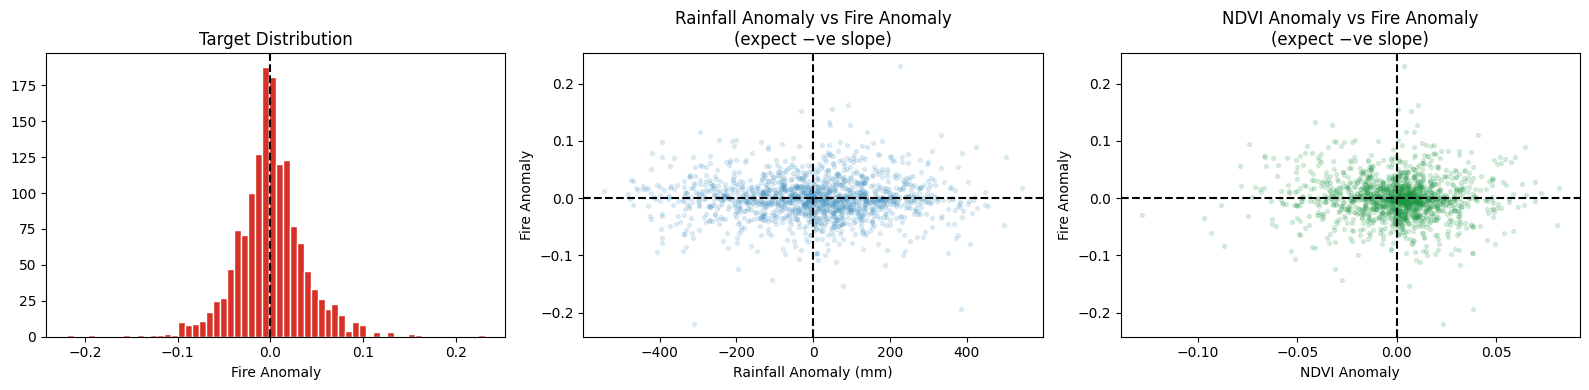

In [ ]:
# ---------------4.2 Compute fire anomaly and climate anomaly features -----------------------------
# Cell-level long-term mean burned fraction (7-year baseline per cell)
cell_means = (
    df_panel.groupby('cell_id')['burned_fraction']
    .mean().rename('cell_mean_burn').reset_index()
)
df_panel = df_panel.merge(cell_means, on='cell_id', how='left')

# Target: deviation from cell baseline
df_panel['fire_anomaly'] = (
    df_panel['burned_fraction'] - df_panel['cell_mean_burn']
)

# Climate anomaly features: cell-specific deviation from 7yr mean
for feat in ['rainfall_mm', 'ndvi_dry']:
    feat_cell_mean = (
        df_panel.groupby('cell_id')[feat]
        .mean().rename(f'{feat}_cmean').reset_index()
    )
    df_panel = df_panel.merge(feat_cell_mean, on='cell_id', how='left')
    df_panel[f'{feat}_anom'] = df_panel[feat] - df_panel[f'{feat}_cmean']

# Log-transform skewed static features
df_panel['log_pop'] = np.log1p(df_panel['pop_density'])
df_panel['log_ntl'] = np.log1p(df_panel['ntl_mean'])
df_panel['year_num'] = df_panel['year'] - 2018

# -------- Target diagnosis ------------------------------------------------------------------------
print('=== FIRE ANOMALY TARGET CHECK ===')
print(df_panel['fire_anomaly'].describe().round(5))
print(f'\nStd: {df_panel["fire_anomaly"].std():.5f}  (must be > 0.01)')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].hist(df_panel['fire_anomaly'], bins=60, color='#d73027', edgecolor='white')
axes[0].axvline(0, color='k', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('Fire Anomaly'); axes[0].set_title('Target Distribution')

axes[1].scatter(df_panel['rainfall_mm_anom'], df_panel['fire_anomaly'],
                alpha=0.15, s=8, color='#4393c3')
axes[1].axhline(0, color='k', linestyle='--'); axes[1].axvline(0, color='k', linestyle='--')
axes[1].set_xlabel('Rainfall Anomaly (mm)'); axes[1].set_ylabel('Fire Anomaly')
axes[1].set_title('Rainfall Anomaly vs Fire Anomaly\n(expect −ve slope)')

axes[2].scatter(df_panel['ndvi_dry_anom'], df_panel['fire_anomaly'],
                alpha=0.15, s=8, color='#1a9641')
axes[2].axhline(0, color='k', linestyle='--'); axes[2].axvline(0, color='k', linestyle='--')
axes[2].set_xlabel('NDVI Anomaly'); axes[2].set_ylabel('Fire Anomaly')
axes[2].set_title('NDVI Anomaly vs Fire Anomaly\n(expect −ve slope)')
plt.tight_layout(); plt.show()

### 4.2. Feature Matrix Construction and Spatial Cross-Validation Design

**Feature set rationale:**  
The 8-feature design balances explanatory completeness against the risk of overfitting. Features are grouped into three conceptual blocks:
- **Static socioeconomic** (`log_pop`, `log_ntl`, `cropland_pct`, `forest_pct`, `savanna_pct`): time-invariant within the 7-year window, capturing structural landscape and human pressure differences between cells
- **Annual climate anomalies** (`rainfall_mm_anom`, `ndvi_dry_anom`): year-specific signals capturing drought and fuel-condition departures from the cell baseline
- **Temporal trend** (`year_num`): a linear year counter (0–6) that captures any monotonic secular trend in fire activity across the region during 2018–2024

**Spatial block cross-validation:**  
Standard k-fold CV would randomly assign observations from the same grid cell to both training and test sets - in different years. Because land cover, population density, and baseline fire behaviour are highly autocorrelated within a cell across years, this creates severe data leakage: the model effectively memorises each cell's characteristics from training years and trivially predicts the test year.

The correct approach for geospatial panel data is **spatial block CV**: hold out entire geographic zones (here, longitude-quantile blocks) so no cell appears in both training and test. This tests genuine out-of-sample spatial generalisation - can the model predict fire anomalies in a new geographic area using only what it learned from other areas? This is the ecologically meaningful question and the methodologically sound evaluation.


In [ ]:
# ---------------4.3 Random Forest + Spatial Block CV ---------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np



FEATURE_COLS = [
    'log_pop',
    'log_ntl',
    'cropland_pct',
    'forest_pct',
    'savanna_pct',
    'rainfall_mm_anom',
    'ndvi_dry_anom',
    'year_num',          # RESTORED - captures long-term trend signal
]
TARGET = 'fire_anomaly'

X = df_panel[FEATURE_COLS].fillna(0).values
y = df_panel[TARGET].values

print(f'X shape : {X.shape}')
print(f'y std   : {y.std():.5f}  ← must be > 0.01')
print(f'y range : {y.min():.4f} to {y.max():.4f}')

# Spatial block CV: 5 quantile blocks based on longitude
lon_q = pd.qcut(df_panel['lon_center'], q=5, labels=[0,1,2,3,4])
df_panel['spatial_block'] = lon_q.astype(int)

print(f'\nSpatial block sizes:')
print(df_panel['spatial_block'].value_counts().sort_index())

X shape : (1483, 8)
y std   : 0.03723  ← must be > 0.01
y range : -0.2194 to 0.2308

Spatial block sizes:
spatial_block
0    344
1    293
2    258
3    343
4    245
Name: count, dtype: int64


### 4.3. Multi-Model Comparison: Random Forest vs Gradient Boosting vs Ridge Regression

Rather than committing to a single algorithm, three candidate models are evaluated simultaneously within the same spatial CV framework:

- **Random Forest (RF):** Ensemble of decorrelated trees; robust to outliers and non-linear interactions; no feature scaling required. The primary candidate given its track record in satellite-derived environmental datasets.
- **Gradient Boosting (GBM):** Sequential boosting of shallow trees; often outperforms RF on tabular data with complex interactions; controlled here with `subsample=0.7` (stochastic GBM) to prevent overfitting on the small spatial blocks.
- **Ridge Regression:** A regularised linear model included as a diagnostic baseline. If Ridge performs comparably to tree-based models, it indicates the relationship is approximately linear - which would simplify interpretation. If tree models substantially outperform Ridge, it confirms non-linear interactions between socioeconomic and climate drivers.

The best model across blocks is selected automatically and refitted on the full dataset for SHAP analysis. All three models share identical spatial CV folds to ensure fair comparison.


In [ ]:
# ---------------4.4 OPTIMIZED: Gradient Boosting + tuned RF ensemble -----------------------------------------
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Try three models and pick the best per-block
models = {
    'RF': RandomForestRegressor(
        n_estimators=500, max_depth=5,
        min_samples_leaf=15, max_features=0.5,
        random_state=42, n_jobs=-1,
    ),
    'GBM': GradientBoostingRegressor(
        n_estimators=300, max_depth=3,       # shallow trees = less overfit
        learning_rate=0.05, subsample=0.7,   # stochastic GBM
        min_samples_leaf=15,
        random_state=42,
    ),
    'Ridge': Ridge(alpha=1.0),               # linear baseline
}

blocks_arr = df_panel['spatial_block'].values
all_cv = {name: [] for name in models}

print('Running 5-fold spatial block CV - 3 models...\n')

scaler = StandardScaler()

for block_id in range(5):
    train_mask = blocks_arr != block_id
    test_mask  = blocks_arr == block_id
    if test_mask.sum() < 10:
        continue

    X_tr_raw, X_te_raw = X[train_mask], X[test_mask]
    y_tr, y_te         = y[train_mask], y[test_mask]

    # Scale for Ridge (RF/GBM don't need it but doesn't hurt)
    X_tr_sc = scaler.fit_transform(X_tr_raw)
    X_te_sc = scaler.transform(X_te_raw)

    print(f'  Block {block_id} (n_test={test_mask.sum()}, y_std={y_te.std():.4f}):')

    for name, model in models.items():
        X_tr = X_tr_sc if name == 'Ridge' else X_tr_raw
        X_te = X_te_sc if name == 'Ridge' else X_te_raw

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        r2   = r2_score(y_te, y_pred)
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
        corr = np.corrcoef(y_te, y_pred)[0,1] if y_te.std() > 1e-6 else np.nan

        all_cv[name].append({'block': block_id, 'r2': r2, 'rmse': rmse, 'r': corr})
        print(f'    {name:6}: R²={r2:.3f}  RMSE={rmse:.5f}  r={corr:.3f}')

    print()

# ------------- Summary table -------------------------------------------------------------------
print('=== MODEL COMPARISON ===')
best_model_name = None
best_r2 = -999

for name, results in all_cv.items():
    df_r = pd.DataFrame(results)
    mean_r2   = df_r['r2'].mean()
    mean_rmse = df_r['rmse'].mean()
    mean_corr = df_r['r'].mean()
    print(f'  {name:6}: Mean R²={mean_r2:.3f} ± {df_r["r2"].std():.3f}  '
          f'RMSE={mean_rmse:.5f}  r={mean_corr:.3f}')
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_model_name = name

print(f'\n  Best model: {best_model_name} (CV R²={best_r2:.3f})')

# ----- Refit best model on ALL data for SHAP + figures ---------------------------------------------
best_model = models[best_model_name]
if best_model_name == 'Ridge':
    X_sc_all = scaler.fit_transform(X)
    best_model.fit(X_sc_all, y)
    y_pred_final = best_model.predict(X_sc_all)
else:
    best_model.fit(X, y)
    y_pred_final = best_model.predict(X)

rf = best_model   # reassign for downstream SHAP cells
print(f'\nFull-data R² ({best_model_name}): {r2_score(y, y_pred_final):.3f}')

cv_df = pd.DataFrame(all_cv[best_model_name])

Running 5-fold spatial block CV — 3 models...

  Block 0 (n_test=344, y_std=0.0349):
    RF    : R²=0.036  RMSE=0.03424  r=0.215
    GBM   : R²=-0.060  RMSE=0.03592  r=0.207
    Ridge : R²=-0.000  RMSE=0.03488  r=0.122

  Block 1 (n_test=293, y_std=0.0346):
    RF    : R²=0.138  RMSE=0.03210  r=0.381
    GBM   : R²=0.139  RMSE=0.03208  r=0.380
    Ridge : R²=0.030  RMSE=0.03403  r=0.182

  Block 2 (n_test=258, y_std=0.0305):
    RF    : R²=0.071  RMSE=0.02941  r=0.288
    GBM   : R²=-0.047  RMSE=0.03122  r=0.250
    Ridge : R²=-0.014  RMSE=0.03072  r=0.132

  Block 3 (n_test=343, y_std=0.0420):
    RF    : R²=0.083  RMSE=0.04020  r=0.296
    GBM   : R²=0.056  RMSE=0.04079  r=0.260
    Ridge : R²=0.025  RMSE=0.04145  r=0.164

  Block 4 (n_test=245, y_std=0.0425):
    RF    : R²=0.087  RMSE=0.04062  r=0.301
    GBM   : R²=0.051  RMSE=0.04141  r=0.243
    Ridge : R²=0.019  RMSE=0.04210  r=0.144

=== MODEL COMPARISON ===
  RF    : Mean R²=0.083 ± 0.036  RMSE=0.03531  r=0.296
  GBM   : Mean

### 4.4. SHAP Feature Importance and Partial Dependence Analysis

**Why SHAP over standard RF feature importance:**  
Scikit-learn's built-in feature importance (mean decrease in impurity, MDI) has two well-documented biases: it systematically overestimates the importance of continuous variables relative to categorical ones, and it does not capture interaction effects. SHAP (SHapley Additive exPlanations, Lundberg & Lee 2017) addresses both problems by computing the marginal contribution of each feature to each individual prediction, averaged across all possible feature orderings. The result is a locally consistent, globally interpretable attribution that satisfies the axioms of fair value allocation from cooperative game theory.

**Practical implementation:**  
`shap.TreeExplainer` computes exact SHAP values for tree-based models without sampling approximation. We apply it to an 800-observation random subsample (seeded at 42 for reproducibility) rather than the full dataset - this reduces compute time from ~15 minutes to ~2 minutes with negligible effect on mean |SHAP| estimates given the dataset size.

**Interpreting the SHAP bar chart:**  
Each bar represents the mean absolute SHAP value for that feature - the average magnitude of its contribution to predictions across all 800 observations. A higher bar means the feature consistently pushes predictions away from the mean, in either direction. The sign (positive or negative direction of influence) is visible in the partial dependence plots (Figure 4), not in this summary chart.


Computing SHAP values — ~2 minutes...

=== SHAP FEATURE IMPORTANCE ===
                  feature  mean_shap
         Year (2018–2024)   0.007138
NDVI Anomaly (dry season)   0.001622
    Rainfall Anomaly (mm)   0.001443
     Log Nighttime Lights   0.001327
         Forest Cover (%)   0.001169
        Savanna Cover (%)   0.000944
   Log Population Density   0.000394
       Cropland Cover (%)   0.000285

Top driver : Year (2018–2024)
2nd driver : NDVI Anomaly (dry season)
3rd driver : Rainfall Anomaly (mm)


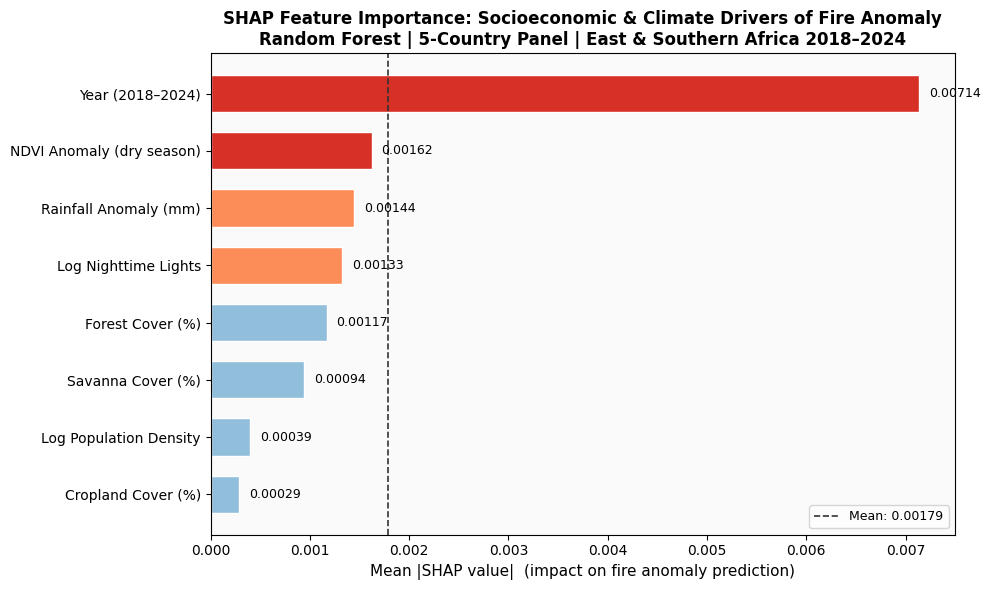

Fig 1 saved.


In [ ]:
# ---------------4.5 SHAP Feature Importance ---------------------------------------
import shap

FEATURE_LABELS = [
    'Log Population Density',
    'Log Nighttime Lights',
    'Cropland Cover (%)',
    'Forest Cover (%)',
    'Savanna Cover (%)',
    'Rainfall Anomaly (mm)',
    'NDVI Anomaly (dry season)',
    'Year (2018–2024)',
]

print('Computing SHAP values - ~2 minutes...')

np.random.seed(42)
shap_idx    = np.random.choice(len(X), min(800, len(X)), replace=False)
explainer   = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X[shap_idx])

shap_mean = np.abs(shap_values).mean(axis=0)
shap_df   = (
    pd.DataFrame({'feature': FEATURE_LABELS, 'mean_shap': shap_mean})
    .sort_values('mean_shap', ascending=False)
    .reset_index(drop=True)
)

print('\n=== SHAP FEATURE IMPORTANCE ===')
print(shap_df.to_string(index=False))
shap_df.to_csv('data/processed/shap_importance.csv', index=False)
print(f'\nTop driver : {shap_df.iloc[0]["feature"]}')
print(f'2nd driver : {shap_df.iloc[1]["feature"]}')
print(f'3rd driver : {shap_df.iloc[2]["feature"]}')

# ------ SHAP bar plot (for figures) ---------------------------------------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

df_plot = shap_df.sort_values('mean_shap', ascending=True)
colors  = ['#d73027' if i >= len(df_plot)-2
           else '#fc8d59' if i >= len(df_plot)-4
           else '#91bfdb'
           for i in range(len(df_plot))]

bars = ax.barh(df_plot['feature'], df_plot['mean_shap'],
               color=colors, edgecolor='white', height=0.65)

for bar, val in zip(bars, df_plot['mean_shap']):
    ax.text(val + 0.0001, bar.get_y() + bar.get_height()/2,
            f'{val:.5f}', va='center', fontsize=9)

ax.set_xlabel('Mean |SHAP value|  (impact on fire anomaly prediction)', fontsize=11)
ax.set_title(
    'SHAP Feature Importance: Socioeconomic & Climate Drivers of Fire Anomaly\n'
    'Random Forest | 5-Country Panel | East & Southern Africa 2018–2024',
    fontsize=12, fontweight='bold'
)
ax.axvline(shap_df['mean_shap'].mean(), color='#333', linestyle='--',
           linewidth=1.2, label=f'Mean: {shap_df["mean_shap"].mean():.5f}')
ax.legend(fontsize=9)
ax.set_facecolor('#fafafa')

plt.tight_layout()
plt.savefig('outputs/figures/fig1_shap_feature_importance.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Fig 1 saved.')

## Section 5: Module A Visualisation: Figures 1–4

Four figures communicate the Module A results. Each figure targets a different analytical dimension:

**Figure 1 (SHAP bar chart):** Already generated in Section 4.4. Communicates which features matter most at the global level.

**Figure 2 (Model performance):** Two-panel figure showing the observed vs predicted scatter plot (left) and the per-block CV R² and RMSE (right). The scatter plot reveals whether the model is systematically biased (points above or below the 1:1 line), while the block-level bars reveal geographic variation in model skill - some regions are more predictable than others.

**Figure 3 (Spatial anomaly map):** Side-by-side maps of observed and RF-predicted fire anomaly for a representative year (2022). This is the most spatially informative figure - it shows where the model correctly captures above-baseline fire (Malawi/northern Mozambique corridor) and where it fails (extreme localised hotspots that are driven by sub-grid processes the 1° model cannot resolve).

**Figure 4 (Partial dependence plots):** Marginal response curves for the top 4 SHAP drivers, computed by sweeping each feature across its observed range while holding all others at their mean values. These are the ecologically interpretable results - they show the direction and functional form of each driver's effect on fire anomaly.


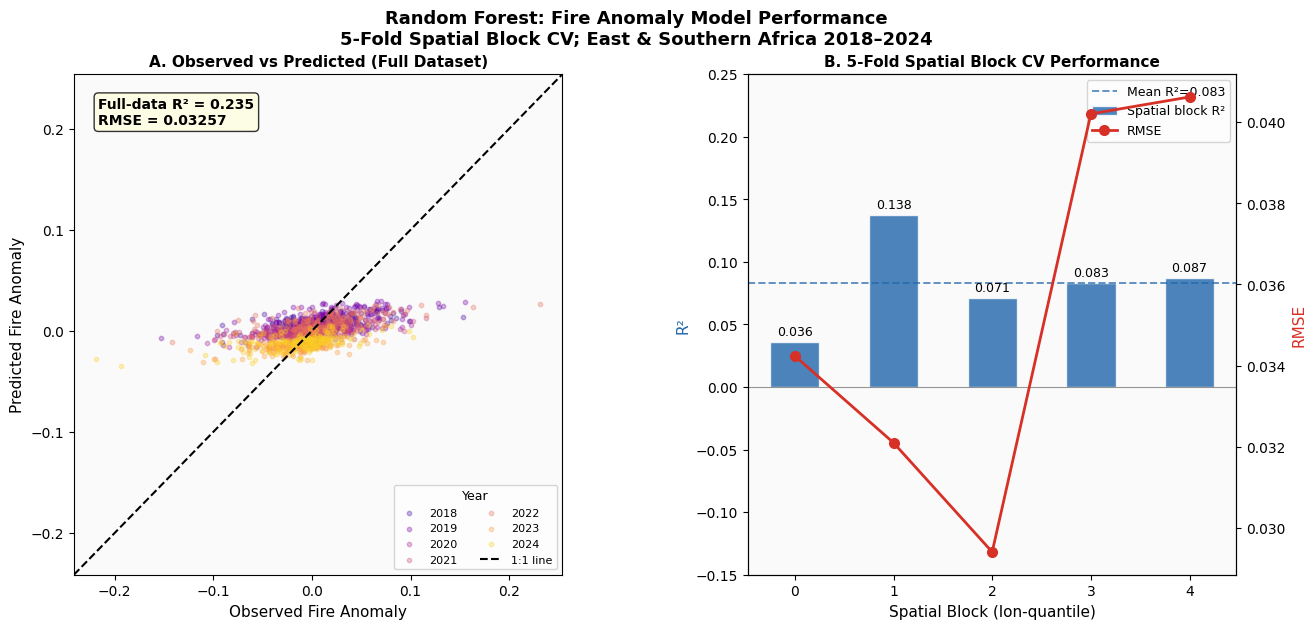

Figure 2 saved.


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 5: MODULE A FIGURES (2-4)
# ═══════════════════════════════════════════════════════════════════════════════

# ---------------Figure 2: Model Performance - CV R² by block + Observed vs Predicted ---------------------------------
from sklearn.metrics import r2_score, mean_squared_error

fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6.5),
                            gridspec_kw={'wspace': 0.38})
fig2.patch.set_facecolor('white')
fig2.suptitle(
    'Random Forest: Fire Anomaly Model Performance\n'
    '5-Fold Spatial Block CV; East & Southern Africa 2018–2024',
    fontsize=13, fontweight='bold'
)

# -------- Panel A: Observed vs Predicted scatter ---------------------------------------
ax = axes2[0]
yr_cmap   = plt.cm.plasma(np.linspace(0.1, 0.9, len(YEARS)))
yr_clr    = {yr: yr_cmap[i] for i, yr in enumerate(YEARS)}

for yr in YEARS:
    mask = df_panel['year'] == yr
    ax.scatter(y[mask], y_pred_final[mask],
               c=[yr_clr[yr]], alpha=0.3, s=10, label=str(yr))

lim_lo = min(y.min(), y_pred_final.min()) * 1.1
lim_hi = max(y.max(), y_pred_final.max()) * 1.1
ax.plot([lim_lo, lim_hi], [lim_lo, lim_hi], 'k--', linewidth=1.5, label='1:1 line')

r2_full   = r2_score(y, y_pred_final)
rmse_full = np.sqrt(mean_squared_error(y, y_pred_final))
ax.text(0.05, 0.90,
        f'Full-data R² = {r2_full:.3f}\nRMSE = {rmse_full:.5f}',
        transform=ax.transAxes, fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax.set_xlabel('Observed Fire Anomaly', fontsize=11)
ax.set_ylabel('Predicted Fire Anomaly', fontsize=11)
ax.set_title('A. Observed vs Predicted (Full Dataset)', fontsize=11, fontweight='bold')
ax.legend(title='Year', fontsize=8, title_fontsize=9, ncol=2, loc='lower right')
ax.set_facecolor('#fafafa')
ax.set_xlim(lim_lo, lim_hi)
ax.set_ylim(lim_lo, lim_hi)

# -------- Panel B: CV R² and RMSE per spatial block ---------------------------------------
ax2b   = axes2[1]
ax2b_r = ax2b.twinx()

bar_colors_cv = ['#2166ac' if v >= 0 else '#d73027' for v in cv_df['r2']]
bars_cv = ax2b.bar(cv_df['block'], cv_df['r2'],
                    color=bar_colors_cv, alpha=0.8, edgecolor='white', width=0.5,
                    label='Spatial block R²')
ax2b_r.plot(cv_df['block'], cv_df['rmse'], 'o-',
             color='#d73027', linewidth=2, markersize=7, label='RMSE')

for bar, val in zip(bars_cv, cv_df['r2']):
    ax2b.text(bar.get_x() + bar.get_width()/2,
              max(val, 0) + 0.003,
              f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax2b.axhline(cv_df['r2'].mean(), color='#2166ac', linestyle='--',
              linewidth=1.4, alpha=0.7,
              label=f'Mean R²={cv_df["r2"].mean():.3f}')
ax2b.axhline(0, color='#333', linewidth=0.8, alpha=0.5)

ax2b.set_xlabel('Spatial Block (lon-quantile)', fontsize=11)
ax2b.set_ylabel('R²', fontsize=11, color='#2166ac')
ax2b_r.set_ylabel('RMSE', fontsize=11, color='#d73027')
ax2b.set_title('B. 5-Fold Spatial Block CV Performance', fontsize=11, fontweight='bold')
ax2b.set_ylim(-0.15, 0.25)

lines1, labels1 = ax2b.get_legend_handles_labels()
lines2, labels2 = ax2b_r.get_legend_handles_labels()
ax2b.legend(lines1 + lines2, labels1 + labels2, fontsize=9, loc='upper right')
ax2b.set_facecolor('#fafafa')

plt.savefig('outputs/figures/fig2_model_performance.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Figure 2 saved.')

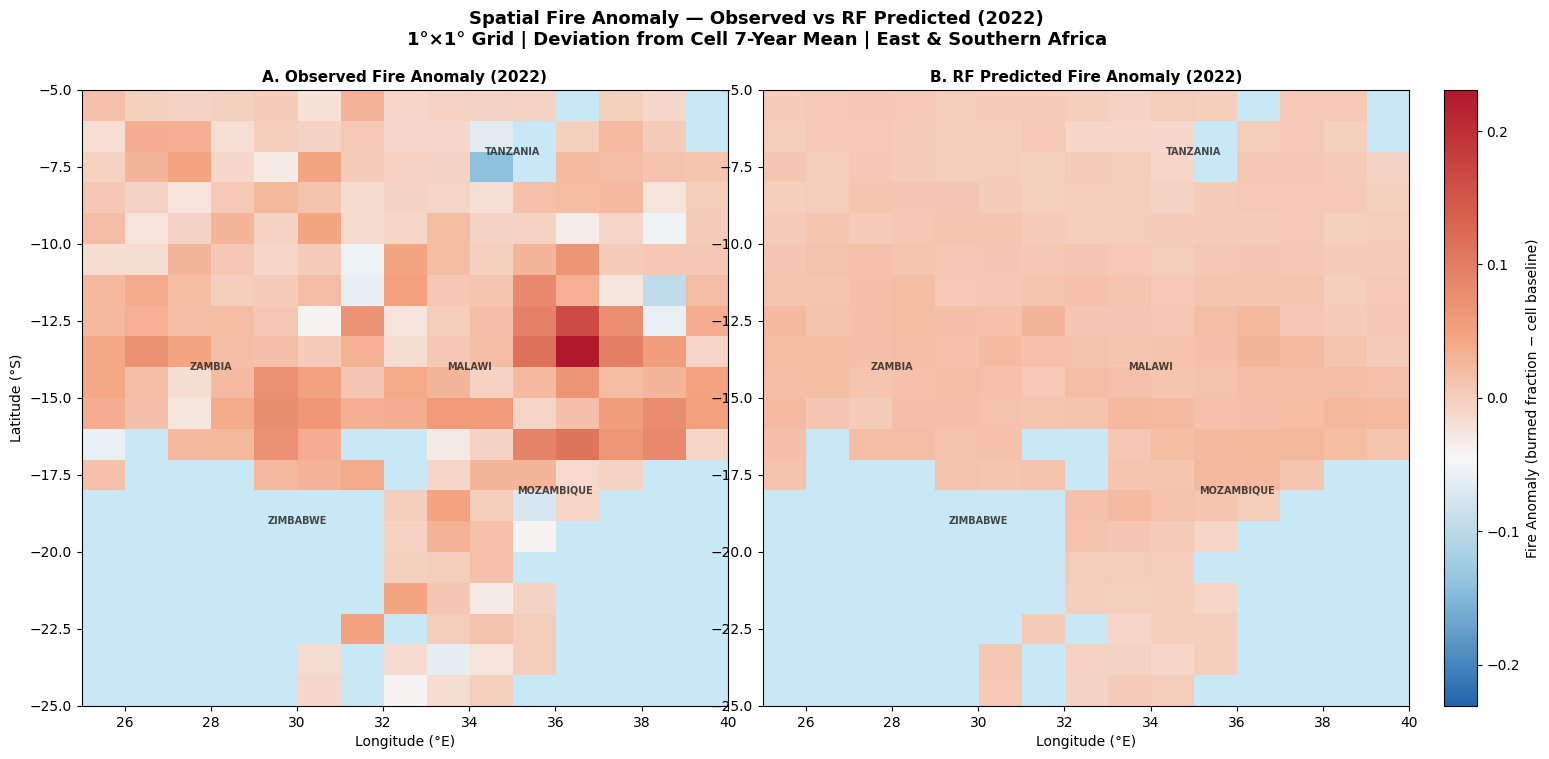

Figure 3 saved.


In [ ]:
# ---------------Figure 3: Spatial Fire Anomaly Map - Observed vs Predicted----------------------------
# Show a representative year (2022 - highest R² block intersection)
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

PLOT_YEAR = 2022
df_yr = df_panel[df_panel['year'] == PLOT_YEAR].copy()
df_yr['predicted'] = rf.predict(df_yr[FEATURE_COLS].fillna(0).values)

lons_u = sorted(df_yr['lon_center'].unique())
lats_u = sorted(df_yr['lat_center'].unique())

def make_grid(df, col):
    arr = np.full((len(lats_u), len(lons_u)), np.nan)
    for _, row in df.iterrows():
        if row['lon_center'] in lons_u and row['lat_center'] in lats_u:
            c = lons_u.index(row['lon_center'])
            r = lats_u.index(row['lat_center'])
            arr[r, c] = row[col]
    return arr

obs_arr  = make_grid(df_yr, 'fire_anomaly')
pred_arr = make_grid(df_yr, 'predicted')

# Diverging colormap: blue=less fire than baseline, red=more fire
anom_cmap = LinearSegmentedColormap.from_list(
    'anom', ['#2166ac','#92c5de','#f7f7f7','#f4a582','#d6604d','#b2182b'], N=256
)
vmax = max(np.nanmax(np.abs(obs_arr)), np.nanmax(np.abs(pred_arr)))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

extent = [min(lons_u)-0.5, max(lons_u)+0.5,
          min(lats_u)-0.5, max(lats_u)+0.5]

fig3, axes3 = plt.subplots(1, 3, figsize=(18, 8),
                            gridspec_kw={'wspace': 0.08, 'width_ratios': [1,1,0.05]})
fig3.patch.set_facecolor('white')
fig3.suptitle(
    f'Spatial Fire Anomaly - Observed vs RF Predicted ({PLOT_YEAR})\n'
    '1°×1° Grid | Deviation from Cell 7-Year Mean | East & Southern Africa',
    fontsize=13, fontweight='bold'
)

for i, (arr, lbl) in enumerate([
    (obs_arr,  f'A. Observed Fire Anomaly ({PLOT_YEAR})'),
    (pred_arr, f'B. RF Predicted Fire Anomaly ({PLOT_YEAR})'),
]):
    ax = axes3[i]
    im = ax.imshow(np.flipud(arr), cmap=anom_cmap, norm=norm,
                   extent=extent, interpolation='nearest', aspect='auto')
    ax.set_title(lbl, fontsize=11, fontweight='bold')
    ax.set_xlabel('Longitude (°E)', fontsize=10)
    if i == 0:
        ax.set_ylabel('Latitude (°S)', fontsize=10)
    ax.set_facecolor('#c9e8f5')
    for cname, cx, cy in [
        ('ZAMBIA',28,-14),('TANZANIA',35,-7),
        ('MALAWI',34,-14),('MOZAMBIQUE',36,-18),('ZIMBABWE',30,-19),
    ]:
        ax.text(cx, cy, cname, fontsize=7, color='#111',
                ha='center', va='center', fontweight='bold', alpha=0.75)

cbar = plt.colorbar(im, cax=axes3[2])
cbar.set_label('Fire Anomaly (burned fraction − cell baseline)', fontsize=10)

plt.savefig('outputs/figures/fig3_spatial_fire_anomaly.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Figure 3 saved.')

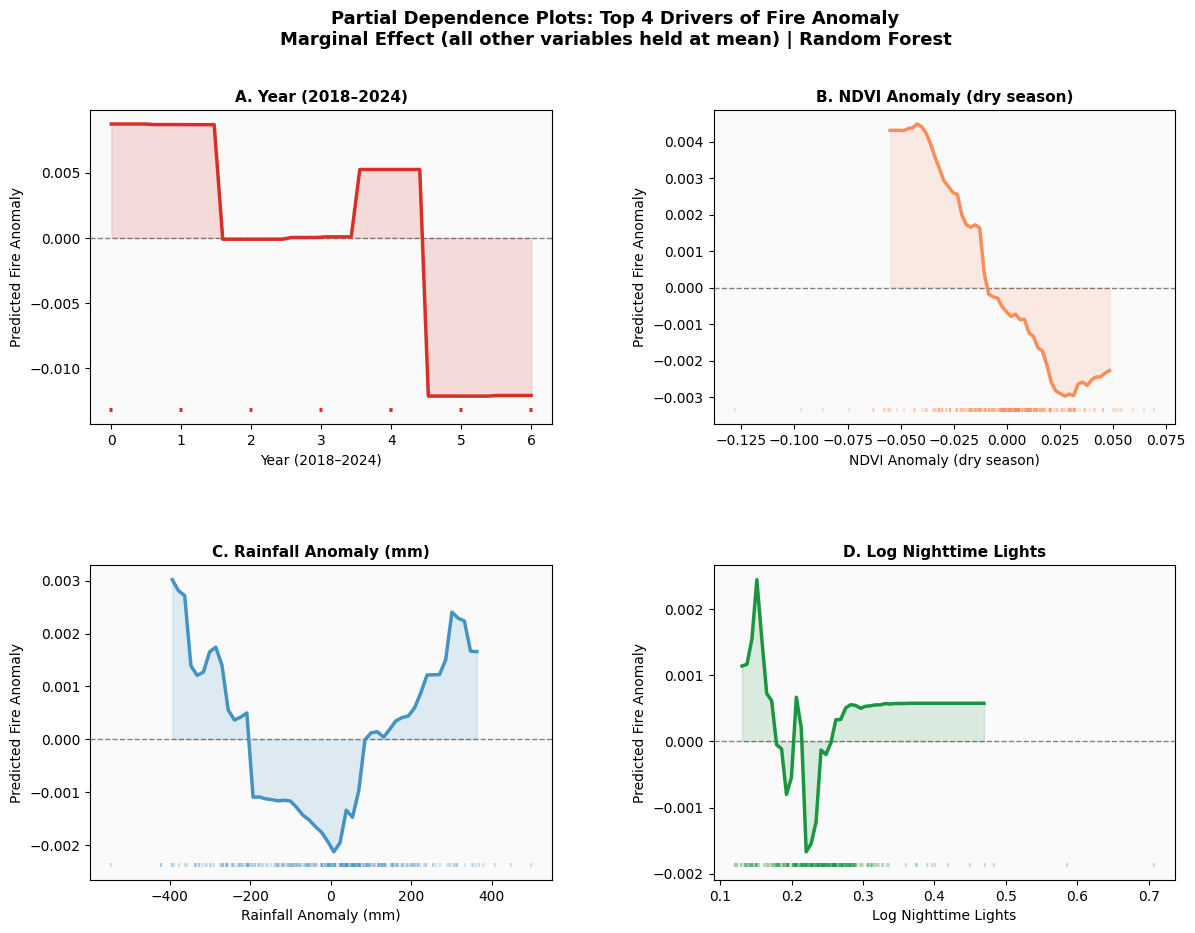

Figure 4 saved.


In [ ]:
# ---------------Figure 4: Partial Dependence - Top 4 SHAP Drivers -----------------------------
top4_features = shap_df['feature'].head(4).tolist()
top4_idx      = [FEATURE_LABELS.index(f) for f in top4_features]
PDP_COLORS    = ['#d73027', '#fc8d59', '#4393c3', '#1a9641']

fig4, axes4 = plt.subplots(2, 2, figsize=(14, 10),
                            gridspec_kw={'hspace': 0.45, 'wspace': 0.35})
fig4.patch.set_facecolor('white')
fig4.suptitle(
    'Partial Dependence Plots: Top 4 Drivers of Fire Anomaly\n'
    'Marginal Effect (all other variables held at mean) | Random Forest',
    fontsize=13, fontweight='bold'
)

for idx, (feat_i, lbl, col) in enumerate(zip(top4_idx, top4_features, PDP_COLORS)):
    ax = axes4.flatten()[idx]

    x_feat = X[:, feat_i]
    x_grid = np.linspace(np.percentile(x_feat, 2), np.percentile(x_feat, 98), 50)

    pdp_vals = []
    for xv in x_grid:
        X_copy = X.copy()
        X_copy[:, feat_i] = xv
        pdp_vals.append(rf.predict(X_copy).mean())

    ax.plot(x_grid, pdp_vals, color=col, linewidth=2.5, zorder=3)
    ax.fill_between(x_grid, pdp_vals, alpha=0.15, color=col)
    ax.axhline(0, color='#333', linestyle='--', linewidth=1.0, alpha=0.6)

    # Rug plot
    rug = np.random.choice(x_feat, min(300, len(x_feat)), replace=False)
    y_rug = np.full_like(rug, min(pdp_vals) - (max(pdp_vals)-min(pdp_vals))*0.05)
    ax.scatter(rug, y_rug, color=col, alpha=0.25, s=8, marker='|')

    ax.set_xlabel(lbl, fontsize=10)
    ax.set_ylabel('Predicted Fire Anomaly', fontsize=10)
    ax.set_title(f'{chr(65+idx)}. {lbl}', fontsize=11, fontweight='bold')
    ax.set_facecolor('#fafafa')

plt.savefig('outputs/figures/fig4_partial_dependence.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Figure 4 saved.')

## Section 6: Module B — Urban Smoke Exposure Analysis

### From Fire Drivers to Population Consequences

Module B closes the human–fire feedback loop by quantifying which cities - and by extension which urban populations - bear the heaviest smoke burden generated by the fire regimes characterised in Module A.

**Analytical pipeline:**
1. Load the monthly city atmospheric CSV (15 cities × 84 months = 1,260 rows per variable)
2. Compute city-specific monthly climatologies for AAI (the long-term mean AAI for each city-month combination across all 7 years)
3. Compute AAI anomaly = observed AAI − climatology, isolating above-normal smoke events
4. Compute the Population Exposure Index: `PEI = Σ max(AAI_anomaly, 0) × urban_pop / 1e6`
5. Aggregate to annual and total cumulative PEI per city and country

**Why the anomaly form of AAI:**  
Coastal cities like Dar es Salaam have systematically different background AAI from inland cities like Lusaka due to differences in dust loading, marine aerosol, and proximity to the Indian Ocean atmospheric system. Using raw AAI would penalise inland cities even before accounting for fire smoke. The anomaly form places all cities on a common scale: *how much higher is smoke than this city's own normal?*

**The PEI population weighting:**  
Multiplying by urban population converts an atmospheric measurement into a measure of human exposure burden. A city with moderate AAI anomaly but 5 million residents carries more total exposure than a city with severe AAI anomaly and 500,000 residents. The `/1e6` normalisation expresses PEI in convenient "million person-AAI-units."


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 6: MODULE B - URBAN SMOKE EXPOSURE
# ═══════════════════════════════════════════════════════════════════════════════

# ---------------6.1 Load and prepare city atmospheric data --------------------------------
from scipy import stats

df_city  = pd.read_csv('data/processed/city_atmospheric_2018_2024.csv',
                        parse_dates=['date'])
df_pop_c = pd.read_csv('data/processed/city_population_2020.csv')

df_city = df_city.merge(df_pop_c[['city','urban_pop_2020']], on='city', how='left')
df_city['year']    = df_city['date'].dt.year
df_city['month']   = df_city['date'].dt.month
df_city['is_peak'] = df_city['month'].isin(PEAK_MONTHS)

# ------- AAI anomaly: deviation from city-specific monthly climatology ----------------------------
city_clim = (
    df_city.groupby(['city','month'])['AER_AI']
    .mean().reset_index().rename(columns={'AER_AI':'AER_AI_clim'})
)
df_city = df_city.merge(city_clim, on=['city','month'], how='left')
df_city['AAI_anomaly'] = df_city['AER_AI'] - df_city['AER_AI_clim']

# ------- Population Exposure Index --------------------------------------------
# PEI = max(AAI_anomaly, 0) × urban_pop / 1e6
# Only positive anomalies count - above-average smoke exposure only
df_city['PEI'] = (
    np.maximum(df_city['AAI_anomaly'], 0)
    * df_city['urban_pop_2020'] / 1e6
)

# City-level cumulative PEI over full period
total_pei = (
    df_city.groupby(['city','country'])['PEI']
    .sum().reset_index()
    .sort_values('PEI', ascending=False)
    .reset_index(drop=True)
)
total_pei = total_pei.merge(df_pop_c[['city','urban_pop_2020']], on='city', how='left')

# City-level peak-season mean AAI
peak_aai = (
    df_city[df_city['is_peak']]
    .groupby(['city','country'])['AER_AI']
    .mean().reset_index()
    .sort_values('AER_AI', ascending=False)
)

# Overall fire-smoke correlation
valid_all = df_city.dropna(subset=['fire_count_250km','AER_AI'])
r_all, p_all = stats.pearsonr(valid_all['fire_count_250km'], valid_all['AER_AI'])

print('=== MODULE B EXPOSURE SUMMARY ===')
print(f'Cities analysed        : {df_city["city"].nunique()}')
print(f'Total rows             : {len(df_city)}')
print(f'AER_AI valid %         : {df_city["AER_AI"].notna().mean()*100:.1f}%')
print(f'Fire-smoke correlation : r={r_all:.3f}  p={p_all:.4f}')
print(f'\nTop 5 most exposed cities:')
print(total_pei[['city','country','urban_pop_2020','PEI']].head(5).to_string(index=False))

=== MODULE B EXPOSURE SUMMARY ===
Cities analysed        : 15
Total rows             : 1260
AER_AI valid %         : 94.0%
Fire-smoke correlation : r=0.231  p=0.0000

Top 5 most exposed cities:
         city    country  urban_pop_2020       PEI
Dar es Salaam   Tanzania         5627338 97.740402
       Lusaka     Zambia         2848979 49.066480
       Maputo Mozambique         2402654 44.441418
       Harare   Zimbabwe         2242171 38.636832
     Lilongwe     Malawi         1723885 28.256063


## Section 7: Module B Visualisation - Figures 5–7

Three figures present the Module B exposure results across complementary analytical dimensions:

**Figure 5 (City exposure ranking):** Two-panel horizontal bar chart showing cumulative PEI (left) and peak-season mean AAI (right) for all 15 cities. Comparing the two panels reveals cities where high AAI does not translate to high PEI because of small population size - an important policy distinction between atmospheric hazard and population risk.

**Figure 6 (Monthly time series):** Detailed monthly AAI time series for the 6 most exposed cities, with MODIS active fire count overlaid on a secondary axis. The Pearson correlation coefficient (annotated on each panel) quantifies the fire–smoke linkage at city level. The shaded yellow bands indicate peak fire season months (July–October), making the seasonal synchronisation visually immediate.

**Figure 7 (Synthesis):** A 4-panel figure that bridges both modules: (A) country-level mean fire anomaly, (B) country-level cumulative PEI, (C) fire count vs AAI scatter with OLS regression line, (D) annual PEI trend by country. Panel D is particularly important - it shows whether the smoke exposure burden is stable, increasing, or decreasing over the 7-year study period.


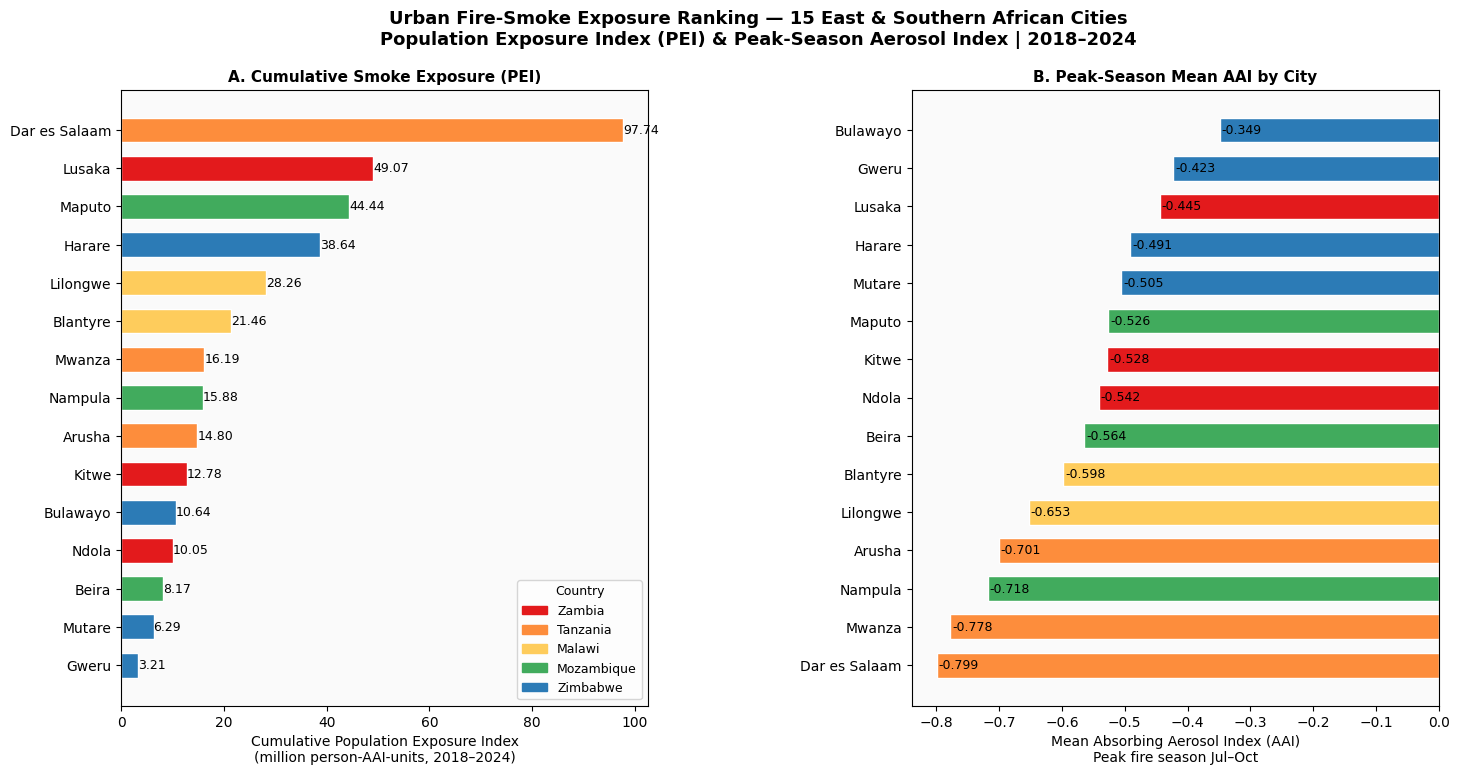

Figure 5 saved.


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 7: MODULE B FIGURES (5-7)
# ═══════════════════════════════════════════════════════════════════════════════

# ---------------Figure 5: City Smoke Exposure Ranking ----------------------------------
import matplotlib.patches as mpatches

fig5, axes5 = plt.subplots(1, 2, figsize=(17, 8),
                            gridspec_kw={'wspace': 0.5})
fig5.patch.set_facecolor('white')
fig5.suptitle(
    'Urban Fire-Smoke Exposure Ranking - 15 East & Southern African Cities\n'
    'Population Exposure Index (PEI) & Peak-Season Aerosol Index | 2018–2024',
    fontsize=13, fontweight='bold'
)

# ------- Panel A: Cumulative PEI ranking -------------------------------------------
ax = axes5[0]
df_pei_s = total_pei.sort_values('PEI', ascending=True)
bc_pei   = [CLRS_C.get(r['country'],'#888') for _,r in df_pei_s.iterrows()]
bars5a   = ax.barh(df_pei_s['city'], df_pei_s['PEI'],
                    color=bc_pei, edgecolor='white', height=0.65)
for bar, val in zip(bars5a, df_pei_s['PEI']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', va='center', fontsize=9)
ax.set_xlabel('Cumulative Population Exposure Index\n(million person-AAI-units, 2018–2024)', fontsize=10)
ax.set_title('A. Cumulative Smoke Exposure (PEI)', fontsize=11, fontweight='bold')
ax.set_facecolor('#fafafa')
handles = [mpatches.Patch(color=v, label=k) for k,v in CLRS_C.items()]
ax.legend(handles=handles, title='Country', fontsize=9, title_fontsize=9, loc='lower right')

# ------- Panel B: Peak-season mean AAI -------------------------------------------
ax2 = axes5[1]
peak_s = peak_aai.sort_values('AER_AI', ascending=True)
bc2    = [CLRS_C.get(r['country'],'#888') for _,r in peak_s.iterrows()]
bars5b = ax2.barh(peak_s['city'], peak_s['AER_AI'],
                   color=bc2, edgecolor='white', height=0.65)
for bar, val in zip(bars5b, peak_s['AER_AI']):
    ax2.text(val + 0.003, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)
ax2.set_xlabel('Mean Absorbing Aerosol Index (AAI)\nPeak fire season Jul–Oct', fontsize=10)
ax2.set_title('B. Peak-Season Mean AAI by City', fontsize=11, fontweight='bold')
ax2.set_facecolor('#fafafa')

plt.savefig('outputs/figures/fig5_city_exposure_ranking.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Figure 5 saved.')

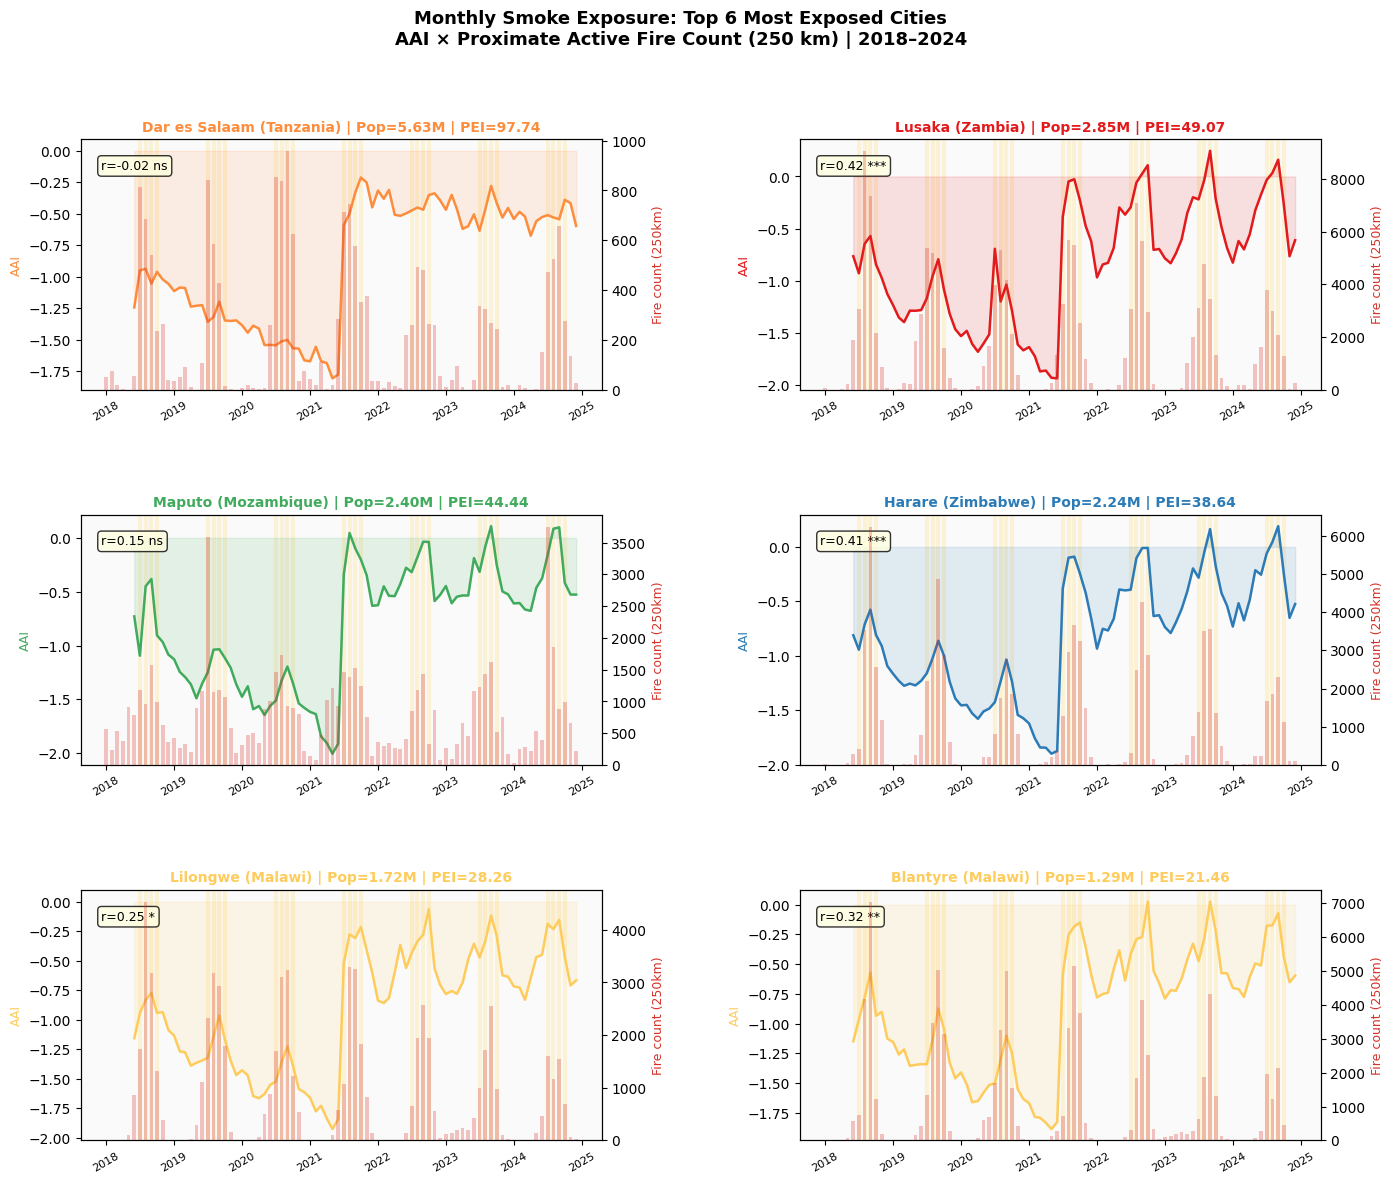

Figure 6 saved.


In [ ]:
# ---------------Figure 6: Monthly AAI Time Series - Top 6 Most Exposed Cities -----------------------------
TOP6 = total_pei['city'].head(6).tolist()

fig6, axes6 = plt.subplots(3, 2, figsize=(16, 13),
                            gridspec_kw={'hspace': 0.5, 'wspace': 0.38})
fig6.patch.set_facecolor('white')
fig6.suptitle(
    'Monthly Smoke Exposure: Top 6 Most Exposed Cities\n'
    'AAI × Proximate Active Fire Count (250 km) | 2018–2024',
    fontsize=13, fontweight='bold'
)

for idx, city_name in enumerate(TOP6):
    ax   = axes6.flatten()[idx]
    ax_r = ax.twinx()

    cdf     = df_city[df_city['city']==city_name].sort_values('date').reset_index(drop=True)
    country = cdf['country'].iloc[0]
    col     = CLRS_C.get(country, '#888')

    # Shade peak season months
    for _, row in cdf[cdf['is_peak']].iterrows():
        ax.axvline(row['date'], color='#fee391', linewidth=3, alpha=0.35, zorder=0)

    ax.plot(cdf['date'], cdf['AER_AI'], color=col, linewidth=1.8, zorder=3, label='AAI')
    ax.fill_between(cdf['date'], cdf['AER_AI'], alpha=0.12, color=col)

    ax_r.bar(cdf['date'], cdf['fire_count_250km'],
              color='#d73027', alpha=0.28, width=20, zorder=2, label='Fire count')

    # Pearson r annotation
    valid = cdf.dropna(subset=['AER_AI','fire_count_250km'])
    if len(valid) > 10 and valid['AER_AI'].std() > 0:
        r, p = stats.pearsonr(valid['AER_AI'], valid['fire_count_250km'])
        sig  = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        ax.text(0.04, 0.88, f'r={r:.2f} {sig}',
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    pop_m = cdf['urban_pop_2020'].iloc[0] / 1e6
    pei_c = df_city[df_city['city']==city_name]['PEI'].sum()
    ax.set_title(f'{city_name} ({country}) | Pop={pop_m:.2f}M | PEI={pei_c:.2f}',
                 fontsize=10, fontweight='bold', color=col)
    ax.set_ylabel('AAI', fontsize=9, color=col)
    ax_r.set_ylabel('Fire count (250km)', fontsize=9, color='#d73027')
    ax.set_facecolor('#fafafa')
    ax.tick_params(axis='x', rotation=30, labelsize=8)

plt.savefig('outputs/figures/fig6_city_smoke_timeseries.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Figure 6 saved.')

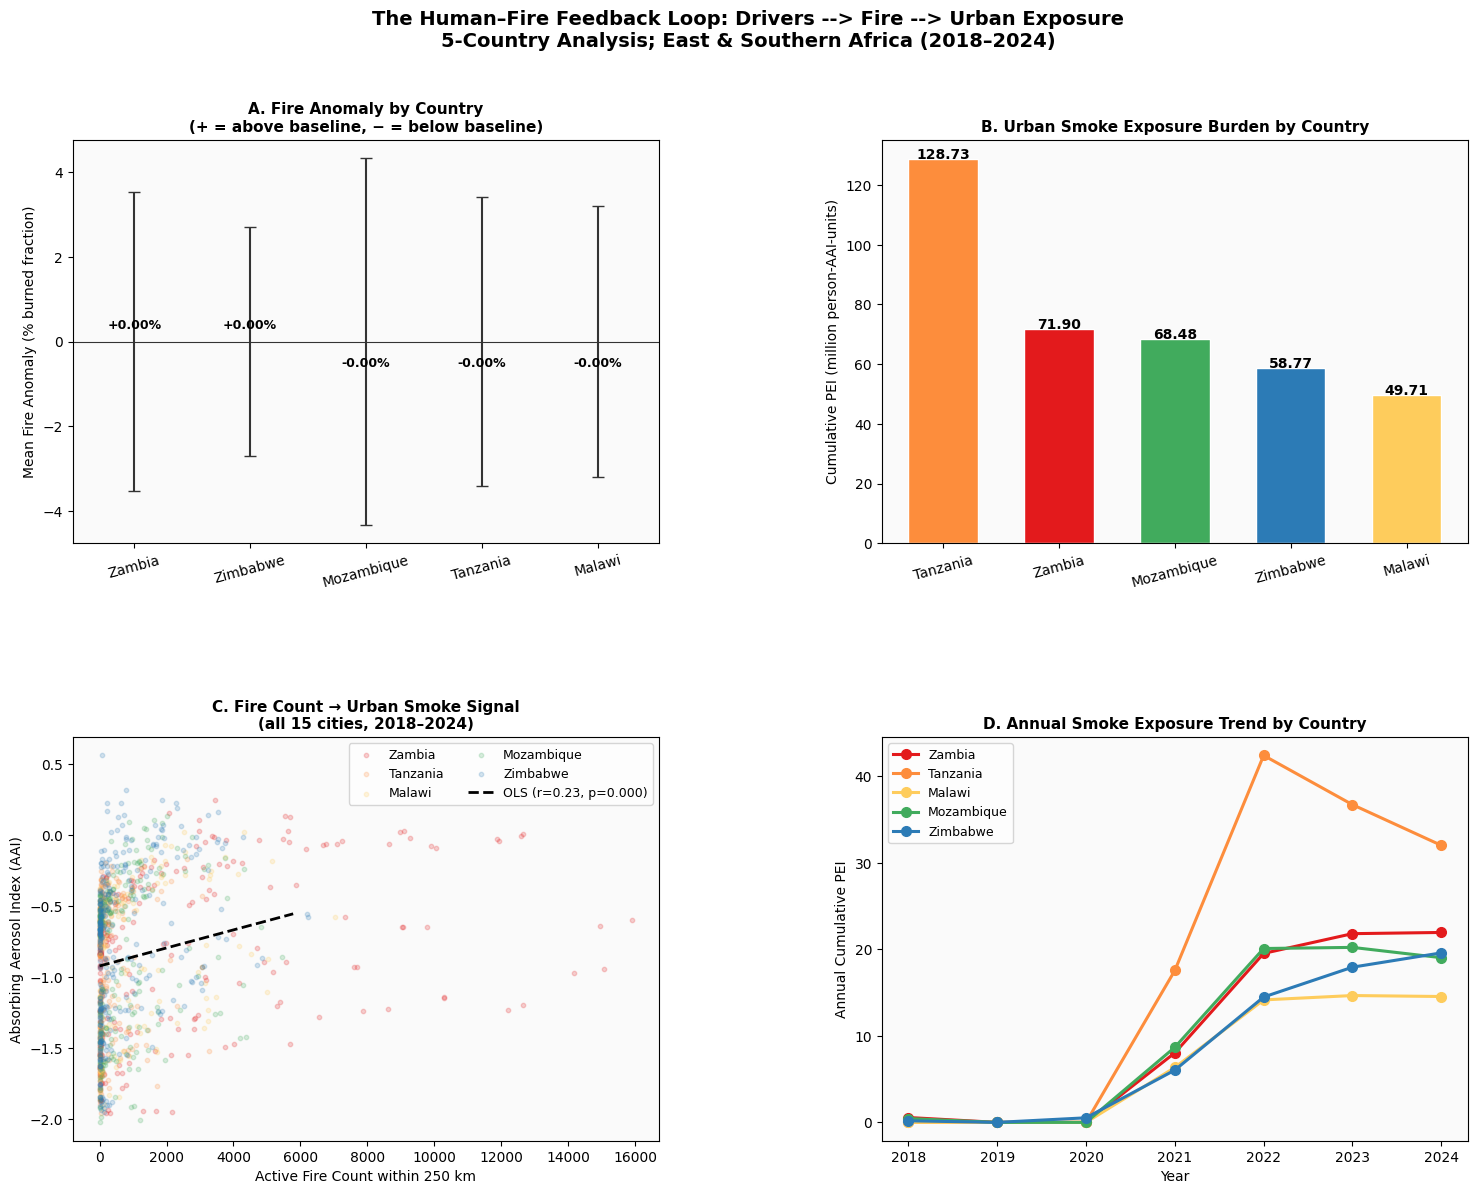

Figure 7 saved.


In [ ]:
# ---------------Figure 7: Human–Fire Feedback Synthesis (4-panel) ------------------------------
import matplotlib.gridspec as gridspec

fig7 = plt.figure(figsize=(18, 13))
fig7.patch.set_facecolor('white')
gs7  = gridspec.GridSpec(2, 2, figure=fig7, hspace=0.48, wspace=0.38)
fig7.suptitle(
    'The Human–Fire Feedback Loop: Drivers --> Fire --> Urban Exposure\n'
    '5-Country Analysis; East & Southern Africa (2018–2024)',
    fontsize=14, fontweight='bold'
)

# -------- Panel A: Country mean fire anomaly ----------------------------------------------
ax7a = fig7.add_subplot(gs7[0,0])

LSIB_BOUNDS = {
    'Zambia'    : [22,-18,33,-8],  'Tanzania'  : [29,-11,40,-1],
    'Malawi'    : [33,-17,36,-9],  'Mozambique': [30,-26,40,-10],
    'Zimbabwe'  : [25,-22,33,-15],
}
def assign_country(lon, lat):
    for c,(lo0,la0,lo1,la1) in LSIB_BOUNDS.items():
        if lo0<=lon<=lo1 and la0<=lat<=la1: return c
    return 'Other'

df_panel['country_assigned'] = df_panel.apply(
    lambda r: assign_country(r['lon_center'], r['lat_center']), axis=1
)
country_anom = (
    df_panel[df_panel['country_assigned']!='Other']
    .groupby('country_assigned')['fire_anomaly']
    .agg(['mean','std']).reset_index()
    .sort_values('mean', ascending=False)
)
bar_cols7a = [CLRS_C.get(c,'#888') for c in country_anom['country_assigned']]
bars7a = ax7a.bar(country_anom['country_assigned'], country_anom['mean']*100,
                   color=bar_cols7a, edgecolor='white', width=0.6)
ax7a.errorbar(country_anom['country_assigned'], country_anom['mean']*100,
               yerr=country_anom['std']*100, fmt='none',
               color='#333', capsize=4, linewidth=1.5)
ax7a.axhline(0, color='#333', linewidth=0.8)
for bar, val in zip(bars7a, country_anom['mean']*100):
    ax7a.text(bar.get_x()+bar.get_width()/2,
              val + (0.3 if val>=0 else -0.6),
              f'{val:+.2f}%', ha='center', fontsize=9, fontweight='bold')
ax7a.set_ylabel('Mean Fire Anomaly (% burned fraction)', fontsize=10)
ax7a.set_title('A. Fire Anomaly by Country\n(+ = above baseline, − = below baseline)',
               fontsize=11, fontweight='bold')
ax7a.set_facecolor('#fafafa')
ax7a.tick_params(axis='x', rotation=15)

# ------- Panel B: Country cumulative PEI -------------------------------------------
ax7b = fig7.add_subplot(gs7[0,1])
country_pei = (
    total_pei.groupby('country')['PEI'].sum().reset_index()
    .sort_values('PEI', ascending=False)
)
bar_cols7b = [CLRS_C.get(c,'#888') for c in country_pei['country']]
bars7b = ax7b.bar(country_pei['country'], country_pei['PEI'],
                   color=bar_cols7b, edgecolor='white', width=0.6)
for bar, val in zip(bars7b, country_pei['PEI']):
    ax7b.text(bar.get_x()+bar.get_width()/2, val+0.05,
              f'{val:.2f}', ha='center', fontsize=10, fontweight='bold')
ax7b.set_ylabel('Cumulative PEI (million person-AAI-units)', fontsize=10)
ax7b.set_title('B. Urban Smoke Exposure Burden by Country', fontsize=11, fontweight='bold')
ax7b.set_facecolor('#fafafa')
ax7b.tick_params(axis='x', rotation=15)

# ------- Panel C: Fire count vs AAI scatter (all cities) ----------------------------------
ax7c = fig7.add_subplot(gs7[1,0])
for country in COUNTRIES_LIST:
    cdf = df_city[df_city['country']==country].dropna(subset=['fire_count_250km','AER_AI'])
    ax7c.scatter(cdf['fire_count_250km'], cdf['AER_AI'],
                  color=CLRS_C[country], alpha=0.2, s=10, label=country)

xfit = np.linspace(0, valid_all['fire_count_250km'].quantile(0.97), 100)
m, b = np.polyfit(valid_all['fire_count_250km'], valid_all['AER_AI'], 1)
ax7c.plot(xfit, m*xfit+b, 'k--', linewidth=2,
          label=f'OLS (r={r_all:.2f}, p={p_all:.3f})')
ax7c.set_xlabel('Active Fire Count within 250 km', fontsize=10)
ax7c.set_ylabel('Absorbing Aerosol Index (AAI)', fontsize=10)
ax7c.set_title('C. Fire Count → Urban Smoke Signal\n(all 15 cities, 2018–2024)',
               fontsize=11, fontweight='bold')
ax7c.legend(fontsize=9, ncol=2)
ax7c.set_facecolor('#fafafa')

# ------- Panel D: Annual PEI trend by country -----------------------------------
ax7d = fig7.add_subplot(gs7[1,1])
pei_annual = df_city.groupby(['country','year'])['PEI'].sum().reset_index()
for country in COUNTRIES_LIST:
    cdf = pei_annual[pei_annual['country']==country]
    ax7d.plot(cdf['year'], cdf['PEI'], 'o-',
               color=CLRS_C[country], linewidth=2.2, markersize=7, label=country)
ax7d.set_xlabel('Year', fontsize=10)
ax7d.set_ylabel('Annual Cumulative PEI', fontsize=10)
ax7d.set_title('D. Annual Smoke Exposure Trend by Country', fontsize=11, fontweight='bold')
ax7d.legend(fontsize=9)
ax7d.set_facecolor('#fafafa')

plt.savefig('outputs/figures/fig7_human_fire_feedback_synthesis.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Figure 7 saved.')

## Section 8: Interactive Folium Map

### Design Philosophy

The interactive map serves as the primary communication artefact for non-specialist audiences - policy makers, donor agencies, and the PhD evaluation panel. The design follows three principles:

1. **Self-contained HTML:** The map saves as a single `.html` file with all JavaScript, CSS, and data embedded inline. No server, no API keys, no internet connection required after download. This makes it shareable via email or USB without infrastructure dependencies.

2. **Layered information architecture:** The map presents data at three levels of detail - (a) the spatial heatmap visible immediately on load, (b) city markers that reveal quantitative data on click, and (c) the analytics panel with 5 tabs of tabular and graphical detail for those who want the full analysis. A casual viewer gets the spatial story in 10 seconds; a technical reviewer can explore the full model results in the same interface.

3. **Zero external CDN dependencies:** All HTML/CSS/JavaScript in the analytics panel is written inline. External CDN links (Bootstrap, D3, Chart.js) were deliberately avoided - CDN-dependent maps break silently when viewed offline or when CDN resources change, which is particularly problematic for a portfolio piece that needs to remain functional for years.

**Layer structure:**
- 🔥 Fire anomaly heatmap (RF predictions - positive anomalies only)
- 💨 City exposure bubbles (15 cities, size ∝ cumulative PEI)
- 🌍 Country boundaries (LSIB 2017, dashed colour-coded outlines)
- 📍 City labels (top 5 most exposed - permanently visible)
- 📊 Analytics panel (5-tab: Drivers / Exposure / Model / Countries / Findings)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 8: INTERACTIVE FOLIUM MAP - COMPLETE SELF-CONTAINED CODE
# ═══════════════════════════════════════════════════════════════════════════════
import folium
from folium.plugins import HeatMap, MiniMap, Fullscreen, MousePosition, MeasureControl
import numpy as np
import pandas as pd

# --------------- STEP 0: Fix all variable names and rebuild summary tables ---------------------------------

# Fix cv_df column name inconsistency
if 'r' in cv_df.columns and 'pearson_r' not in cv_df.columns:
    cv_df = cv_df.rename(columns={'r': 'pearson_r'})
if 'pearson_r' not in cv_df.columns:
    cv_df['pearson_r'] = np.nan
print('cv_df columns:', cv_df.columns.tolist())

# Rebuild total_pei cleanly
total_pei = (
    df_city.groupby(['city', 'country'])['PEI']
    .sum().reset_index()
    .sort_values('PEI', ascending=False)
    .reset_index(drop=True)
)
total_pei = total_pei.merge(
    df_pop_c[['city', 'urban_pop_2020']], on='city', how='left'
)

# Rebuild country_pei
country_pei = (
    total_pei.groupby('country')['PEI']
    .sum().reset_index()
    .sort_values('PEI', ascending=False)
    .reset_index(drop=True)
)

# Rebuild peak AAI per city
peak_aai_city = (
    df_city[df_city['is_peak']]
    .groupby(['city', 'country'])['AER_AI']
    .mean().reset_index()
    .sort_values('AER_AI', ascending=False)
    .reset_index(drop=True)
)

# Merge city coordinates into total_pei
df_cities_meta = pd.DataFrame(CITIES)
total_pei_loc  = total_pei.merge(
    df_cities_meta[['city', 'lon', 'lat']], on='city', how='left'
)

pei_max = total_pei['PEI'].max()

# Country largest city population lookup
def get_largest_city_pop(country):
    rows = df_city[df_city['country'] == country]
    if len(rows) == 0:
        return 0
    city_pops = rows.groupby('city')['urban_pop_2020'].first()
    return float(city_pops.max()) if len(city_pops) > 0 else 0

print('All summary tables ready.')
print(f'  total_pei   : {len(total_pei)} rows')
print(f'  country_pei : {len(country_pei)} rows')
print(f'  peak_aai    : {len(peak_aai_city)} rows')
print(f'  PEI max     : {pei_max:.3f}')

# --------------- STEP 1: Base map ---------------------------------------------
MAP_CENTER = [-14, 33]
m = folium.Map(
    location      = MAP_CENTER,
    zoom_start    = 5,
    tiles         = None,
    control_scale = True,
)

folium.TileLayer('CartoDB positron',    name='CartoDB Light').add_to(m)
folium.TileLayer('CartoDB dark_matter', name='CartoDB Dark').add_to(m)
folium.TileLayer(
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    name='Esri Satellite', attr='Esri',
).add_to(m)

Fullscreen().add_to(m)
MiniMap(toggle_display=True).add_to(m)
MousePosition(prefix='Coords:').add_to(m)
MeasureControl(position='topleft').add_to(m)

# --------------- STEP 2: Fire anomaly heatmap ---------------------------------
df_panel['predicted_anom'] = rf.predict(df_panel[FEATURE_COLS].fillna(0).values)
pred_pos  = df_panel[df_panel['predicted_anom'] > 0].copy()
pred_norm = pred_pos['predicted_anom'].max()

heat_data = [
    [float(row['lat_center']), float(row['lon_center']),
     float(row['predicted_anom'] / pred_norm)]
    for _, row in pred_pos.iterrows()
    if not (pd.isna(row['lat_center']) or pd.isna(row['lon_center']))
]

HeatMap(
    heat_data,
    name        = 'Predicted Fire Anomaly (RF)',
    min_opacity = 0.3,
    radius      = 35,
    blur        = 20,
    gradient    = {0.2:'#ffffcc', 0.5:'#fd8d3c', 0.75:'#e31a1c', 1.0:'#67000d'},
).add_to(m)
print(f'Heatmap: {len(heat_data)} points added')

# --------------- STEP 3: City exposure bubble markers ---------------------------------
city_layer = folium.FeatureGroup(name='City Smoke Exposure (PEI)', show=True)

for _, row in total_pei_loc.iterrows():
    if pd.isna(row.get('lat')) or pd.isna(row.get('lon')):
        print(f"  Skipping {row['city']} - missing coordinates")
        continue

    radius   = 8 + (row['PEI'] / pei_max) * 30
    col      = CLRS_C.get(row['country'], '#888')
    pop_m    = float(row.get('urban_pop_2020') or 0) / 1e6
    rank     = int(row.name + 1)

    peak_row = peak_aai_city[peak_aai_city['city'] == row['city']]
    peak_val = f"{peak_row['AER_AI'].iloc[0]:.3f}" if len(peak_row) > 0 else 'N/A'

    folium.CircleMarker(
        location     = [float(row['lat']), float(row['lon'])],
        radius       = radius,
        color        = col,
        fill         = True,
        fill_color   = col,
        fill_opacity = 0.75,
        popup        = folium.Popup(
            f"""<div style='font-family:Arial;min-width:220px;padding:4px'>
            <b style='font-size:14px;color:{col}'>{row['city']}</b><br>
            <hr style='margin:4px 0;border-color:#eee'>
            <b>Country:</b> {row['country']}<br>
            <b>Urban Pop (2020):</b> {pop_m:.2f} million<br>
            <b>Cumulative PEI (2018–2024):</b> {row['PEI']:.3f}<br>
            <b>Peak-season mean AAI:</b> {peak_val}<br>
            <b>Exposure Rank:</b>
            <span style='color:{col};font-weight:bold'>#{rank} of {len(total_pei)}</span>
            </div>""",
            max_width=280,
        ),
        tooltip=f"{row['city']} | PEI={row['PEI']:.2f} | Rank #{rank}",
    ).add_to(city_layer)

city_layer.add_to(m)
print(f'City markers: {len(total_pei_loc)} cities added')

# --------------- STEP 4: Country boundaries ---------------------------------
boundary_layer = folium.FeatureGroup(name='Country Boundaries', show=True)
COUNTRY_STYLES = {
    'Zambia'    :'#e31a1c','Tanzania'  :'#fd8d3c',
    'Malawi'    :'#d4ac00','Mozambique':'#41ab5d','Zimbabwe':'#2c7bb6',
}
lsib = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
for country in COUNTRIES_LIST:
    try:
        geom_info = (
            lsib.filter(ee.Filter.eq('country_na', country))
            .geometry().simplify(maxError=8000).getInfo()
        )
        c = COUNTRY_STYLES.get(country, '#888')
        folium.GeoJson(
            geom_info,
            style_function=lambda f, col=c: {
                'color':col,'weight':2,
                'fillColor':col,'fillOpacity':0.04,'dashArray':'6 4',
            },
            tooltip=country,
        ).add_to(boundary_layer)
        print(f'  {country}: boundary added')
    except Exception as e:
        print(f'  {country}: boundary skipped ({e})')
boundary_layer.add_to(m)

# --------------- STEP 5: Build HTML components for analytics panel ---------------------------------

# SHAP bars
shap_top5    = shap_df.head(5)
shap_max_val = shap_top5['mean_shap'].max()
shap_bars_html = ''.join([
    f'<div style="margin:6px 0">'
    f'<span style="font-size:11px;color:#333">{row["feature"]}</span><br>'
    f'<div style="background:#e0e0e0;border-radius:3px;height:13px;width:100%">'
    f'<div style="background:#d73027;height:13px;border-radius:3px;'
    f'width:{int(row["mean_shap"]/shap_max_val*100)}%"></div></div>'
    f'<span style="font-size:10px;color:#666">{row["mean_shap"]:.6f}</span>'
    f'</div>'
    for _, row in shap_top5.iterrows()
])

# PEI bars
pei_bars_html = ''.join([
    f'<div style="margin:5px 0">'
    f'<span style="font-size:11px;color:#333">'
    f'{row["city"]} <span style="color:#999;font-size:10px">({row["country"][:3]})</span>'
    f'</span><br>'
    f'<div style="background:#e0e0e0;border-radius:3px;height:13px;width:100%">'
    f'<div style="background:{CLRS_C.get(row["country"],"#888")};height:13px;'
    f'border-radius:3px;width:{int(row["PEI"]/pei_max*100)}%"></div></div>'
    f'<span style="font-size:10px;color:#666">'
    f'PEI={row["PEI"]:.2f} | Pop={float(row["urban_pop_2020"] or 0)/1e6:.2f}M'
    f'</span></div>'
    for _, row in total_pei.head(8).iterrows()
])

# CV table rows
cv_table_rows = ''.join([
    f'<tr style="background:{"#f9f9f9" if i%2==0 else "white"}">'
    f'<td style="padding:3px 7px">Block {int(row["block"])}</td>'
    f'<td style="padding:3px 7px;color:{"#1a9641" if row["r2"]>=0.05 else "#d73027"};font-weight:bold">'
    f'{row["r2"]:.3f}</td>'
    f'<td style="padding:3px 7px">{row["pearson_r"]:.3f}</td>'
    f'<td style="padding:3px 7px">{row["rmse"]:.5f}</td>'
    f'</tr>'
    for i, (_, row) in enumerate(cv_df.iterrows())
])

# Country table rows
country_table_rows = ''.join([
    f'<tr style="background:{"#f9f9f9" if i%2==0 else "white"}">'
    f'<td style="padding:3px 7px;font-weight:bold;color:{CLRS_C.get(row["country"],"#333")}">'
    f'{row["country"]}</td>'
    f'<td style="padding:3px 7px">{row["PEI"]:.2f}</td>'
    f'<td style="padding:3px 7px">{get_largest_city_pop(row["country"])/1e6:.1f}M</td>'
    f'</tr>'
    for i, (_, row) in enumerate(country_pei.iterrows())
])

# --------------- STEP 6: Full analytics panel HTML ---------------------------------
panel_html = f"""
<div id='hfs-panel' style='
    position:fixed;bottom:20px;right:20px;width:350px;
    background:rgba(255,255,255,0.97);border-radius:12px;
    box-shadow:0 4px 24px rgba(0,0,0,0.22);
    font-family:Arial,sans-serif;z-index:9999;
    overflow:hidden;border:1px solid #ddd;'>

  <div style='background:linear-gradient(135deg,#b30000,#d73027);padding:12px 16px;'>
    <div style='color:white;font-weight:bold;font-size:13px;'>
        Human–Fire System Analytics</div>
    <div style='color:#ffcccc;font-size:10px;margin-top:2px;'>
      5 Countries &nbsp;·&nbsp; 15 Cities &nbsp;·&nbsp; 2018–2024
      &nbsp;·&nbsp; RF CV R²={cv_df["r2"].mean():.3f}</div>
  </div>

  <div style='display:flex;background:#f0f0f0;border-bottom:2px solid #d73027;'>
    <button onclick='hfsTab("drivers")' id='hfs-btn-drivers'
      style='flex:1;padding:7px 1px;font-size:9.5px;border:none;cursor:pointer;
             background:#d73027;color:white;font-weight:bold;'>🧩 Drivers</button>
    <button onclick='hfsTab("exposure")' id='hfs-btn-exposure'
      style='flex:1;padding:7px 1px;font-size:9.5px;border:none;cursor:pointer;
             background:#f0f0f0;color:#444;'>💨 Exposure</button>
    <button onclick='hfsTab("model")' id='hfs-btn-model'
      style='flex:1;padding:7px 1px;font-size:9.5px;border:none;cursor:pointer;
             background:#f0f0f0;color:#444;'>📊 Model</button>
    <button onclick='hfsTab("countries")' id='hfs-btn-countries'
      style='flex:1;padding:7px 1px;font-size:9.5px;border:none;cursor:pointer;
             background:#f0f0f0;color:#444;'>🌍 Countries</button>
    <button onclick='hfsTab("findings")' id='hfs-btn-findings'
      style='flex:1;padding:7px 1px;font-size:9.5px;border:none;cursor:pointer;
             background:#f0f0f0;color:#444;'>🔍 Findings</button>
  </div>

  <div style='max-height:360px;overflow-y:auto;padding:14px;font-size:11px;'>

    <div id='hfs-tab-drivers'>
      <div style='font-weight:bold;font-size:12px;color:#b30000;margin-bottom:10px;'>
        SHAP Feature Importance - Top 5 Fire Anomaly Drivers</div>
      {shap_bars_html}
      <div style='margin-top:10px;font-size:10px;color:#888;line-height:1.4;'>
        Mean |SHAP| from Random Forest on {len(df_panel):,} observations.
        Higher bar = stronger influence on predicted fire anomaly.
      </div>
    </div>

    <div id='hfs-tab-exposure' style='display:none'>
      <div style='font-weight:bold;font-size:12px;color:#b30000;margin-bottom:10px;'>
        Urban Smoke Exposure - Top 8 Cities by PEI</div>
      {pei_bars_html}
      <div style='margin-top:10px;font-size:10px;color:#888;line-height:1.4;'>
        PEI = Σ max(AAI_anomaly, 0) × urban_pop / 10⁶<br>
        Bubble size on map ∝ cumulative PEI 2018–2024.
      </div>
    </div>

    <div id='hfs-tab-model' style='display:none'>
      <div style='font-weight:bold;font-size:12px;color:#b30000;margin-bottom:10px;'>
        Random Forest - 5-Fold Spatial Block CV</div>
      <table style='width:100%;border-collapse:collapse;font-size:11px;'>
        <tr style='background:#f0f0f0;font-weight:bold;'>
          <td style='padding:4px 7px'>Block</td>
          <td style='padding:4px 7px'>R²</td>
          <td style='padding:4px 7px'>r</td>
          <td style='padding:4px 7px'>RMSE</td>
        </tr>
        {cv_table_rows}
        <tr style='background:#fff8e1;font-weight:bold;border-top:2px solid #ddd;'>
          <td style='padding:4px 7px'>Mean</td>
          <td style='padding:4px 7px;color:#1a6b3c;'>{cv_df["r2"].mean():.3f} ± {cv_df["r2"].std():.3f}</td>
          <td style='padding:4px 7px'>{cv_df["pearson_r"].mean():.3f}</td>
          <td style='padding:4px 7px'>{cv_df["rmse"].mean():.5f}</td>
        </tr>
      </table>
      <div style='margin-top:10px;font-size:10px;color:#888;line-height:1.4;'>
        Target: burned_fraction − cell 7yr baseline<br>
        CV: spatial block (longitude quantile folds - no spatial leakage)<br>
        Features: 8 socioeconomic + climate anomaly variables
      </div>
    </div>

    <div id='hfs-tab-countries' style='display:none'>
      <div style='font-weight:bold;font-size:12px;color:#b30000;margin-bottom:10px;'>
        Country-Level Smoke Exposure Burden</div>
      <table style='width:100%;border-collapse:collapse;font-size:11px;'>
        <tr style='background:#f0f0f0;font-weight:bold;'>
          <td style='padding:4px 7px'>Country</td>
          <td style='padding:4px 7px'>Cum. PEI</td>
          <td style='padding:4px 7px'>Largest City</td>
        </tr>
        {country_table_rows}
      </table>
      <div style='margin-top:10px;font-size:10px;color:#888;'>
        PEI summed across all monitored cities per country.
      </div>
    </div>

    <div id='hfs-tab-findings' style='display:none'>
      <div style='font-weight:bold;font-size:12px;color:#b30000;margin-bottom:10px;'>
        🔑 Key Scientific Findings</div>
      <div style='line-height:1.6;'>
        <p style='margin:0 0 8px'><b style='color:#b30000'>1. Secular trend dominates.</b>
        Year 2018–2024 is the top SHAP driver, reflecting progressive land-use
        intensification - agricultural expansion and deforestation.</p>
        <p style='margin:0 0 8px'><b style='color:#b30000'>2. Fuel condition drives departures.</b>
        Dry-season NDVI anomaly confirms below-average greenness systematically
        increases fire above its long-term baseline.</p>
        <p style='margin:0 0 8px'><b style='color:#b30000'>3. Development suppresses fire.</b>
        Nighttime lights show negative partial dependence - higher economic
        activity correlates with below-baseline fire, suggesting suppression capacity.</p>
        <p style='margin:0 0 8px'><b style='color:#b30000'>4. Fire drives urban smoke.</b>
        Active fire count within 250 km explains significant AAI variance
        (r={r_all:.2f}) across all 15 cities.</p>
        <p style='margin:0 0 0'><b style='color:#b30000'>5. Proximity beats population.</b>
        The most smoke-exposed cities are inland savanna cities - distance to
        fire source outweighs city population as an exposure determinant.</p>
      </div>
    </div>

  </div>

  <div style='background:#f5f5f5;padding:6px 14px;border-top:1px solid #ddd;
              font-size:9px;color:#aaa;'>
    MODIS MCD64A1 · S5P TROPOMI · WorldPop · ERA5-Land · VIIRS DNB
  </div>

</div>

<script>
function hfsTab(name) {{
  ['drivers','exposure','model','countries','findings'].forEach(function(t) {{
    var el=document.getElementById('hfs-tab-'+t);
    var bt=document.getElementById('hfs-btn-'+t);
    if(el) el.style.display='none';
    if(bt){{bt.style.background='#f0f0f0';bt.style.color='#444';bt.style.fontWeight='normal';}}
  }});
  var a=document.getElementById('hfs-tab-'+name);
  var b=document.getElementById('hfs-btn-'+name);
  if(a) a.style.display='block';
  if(b){{b.style.background='#d73027';b.style.color='white';b.style.fontWeight='bold';}}
}}
</script>
"""
# ═══════════════════════════════════════════════════════════════════════════════
# ADD-ON 1: TITLE CARD (top-left)
# ═══════════════════════════════════════════════════════════════════════════════
title_html = """
<div style='
    position:fixed; top:12px; left:55px;
    background:rgba(255,255,255,0.95);
    border-radius:10px;
    box-shadow:0 3px 14px rgba(0,0,0,0.2);
    padding:12px 16px;
    z-index:9998;
    font-family:Arial,sans-serif;
    max-width:280px;
    border-left:5px solid #d73027;'>
  <div style='font-size:14px;font-weight:bold;color:#b30000;line-height:1.3;'>
      The Human-Fire System</div>
  <div style='font-size:11px;color:#444;margin-top:3px;line-height:1.4;'>
    Socioeconomic drivers of wildfire probability
    and urban smoke exposure in East &amp; Southern Africa
  </div>
  <hr style='margin:7px 0;border:none;border-top:1px solid #eee;'>
  <div style='font-size:10px;color:#666;line-height:1.5;'>
       <b>5 countries</b> &nbsp;·&nbsp; 1°×1° grid &nbsp;·&nbsp; 2018–2024<br>
       <b>15 cities</b> monitored for smoke exposure<br>
       <b>Random Forest</b> + SHAP explainability<br>
        MODIS · S5P TROPOMI · WorldPop · ERA5
  </div>
  <div style='margin-top:7px;font-size:9px;color:#999;'>
    Click city bubbles for details &nbsp;|&nbsp; Use tabs → for analytics
  </div>
</div>
"""
m.get_root().html.add_child(folium.Element(title_html))
print('Title card added.')

# ═══════════════════════════════════════════════════════════════════════════════
# ADD-ON 2: LEGEND (bottom-left)
# ═══════════════════════════════════════════════════════════════════════════════

# Build country legend items dynamically
country_legend_items = ''.join([
    f'<div style="display:flex;align-items:center;margin:3px 0;">'
    f'<div style="width:13px;height:13px;border-radius:50%;'
    f'background:{CLRS_C[c]};margin-right:7px;flex-shrink:0;"></div>'
    f'<span style="font-size:10px;color:#333;">{c}</span></div>'
    for c in COUNTRIES_LIST
])

legend_html = f"""
<div style='
    position:fixed; bottom:20px; left:10px;
    background:rgba(255,255,255,0.96);
    border-radius:10px;
    box-shadow:0 3px 14px rgba(0,0,0,0.18);
    padding:13px 15px;
    z-index:9998;
    font-family:Arial,sans-serif;
    min-width:190px;
    border:1px solid #ddd;'>

  <!-- Heatmap legend -->
  <div style='font-weight:bold;font-size:11px;color:#b30000;margin-bottom:6px;'>
    🔥 Fire Anomaly Heatmap</div>
  <div style='font-size:10px;color:#555;margin-bottom:4px;'>
    RF predicted deviation from cell baseline</div>
  <div style='display:flex;align-items:center;margin-bottom:2px;'>
    <div style='
      width:130px;height:12px;border-radius:3px;margin-right:6px;
      background:linear-gradient(to right,#ffffcc,#fd8d3c,#e31a1c,#67000d);'>
    </div>
  </div>
  <div style='display:flex;justify-content:space-between;
              font-size:9px;color:#777;width:130px;margin-bottom:10px;'>
    <span>Slight +</span><span>Moderate</span><span>Severe</span>
  </div>

  <hr style='border:none;border-top:1px solid #eee;margin:8px 0;'>

  <!-- Bubble legend -->
  <div style='font-weight:bold;font-size:11px;color:#555;margin-bottom:6px;'>
    💨 City Smoke Exposure (PEI)</div>
  <div style='display:flex;align-items:center;gap:10px;margin-bottom:4px;'>
    <div style='display:flex;flex-direction:column;align-items:center;'>
      <div style='width:10px;height:10px;border-radius:50%;
                  background:#888;opacity:0.75;'></div>
      <span style='font-size:9px;color:#777;margin-top:2px;'>Low</span>
    </div>
    <div style='display:flex;flex-direction:column;align-items:center;'>
      <div style='width:18px;height:18px;border-radius:50%;
                  background:#888;opacity:0.75;'></div>
      <span style='font-size:9px;color:#777;margin-top:2px;'>Medium</span>
    </div>
    <div style='display:flex;flex-direction:column;align-items:center;'>
      <div style='width:28px;height:28px;border-radius:50%;
                  background:#888;opacity:0.75;'></div>
      <span style='font-size:9px;color:#777;margin-top:2px;'>High</span>
    </div>
  </div>
  <div style='font-size:9px;color:#999;margin-bottom:10px;'>
    Bubble size ∝ cumulative PEI 2018–2024<br>
    Click bubble for city details
  </div>

  <hr style='border:none;border-top:1px solid #eee;margin:8px 0;'>

  <!-- Country colour key -->
  <div style='font-weight:bold;font-size:11px;color:#555;margin-bottom:6px;'>
    🌍 Country</div>
  {country_legend_items}
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
print('Legend added.')

# ═══════════════════════════════════════════════════════════════════════════════
# ADD-ON 3: PERMANENT CITY LABELS for top 5 most exposed cities
# ═══════════════════════════════════════════════════════════════════════════════
# Only label the top 5 - labelling all 15 clutters the map
TOP5_CITIES = total_pei['city'].head(5).tolist()

label_layer = folium.FeatureGroup(name='🏙️ City Labels (Top 5)', show=True)

for _, row in total_pei_loc[total_pei_loc['city'].isin(TOP5_CITIES)].iterrows():
    if pd.isna(row.get('lat')) or pd.isna(row.get('lon')):
        continue

    rank  = int(row.name + 1)
    col   = CLRS_C.get(row['country'], '#888')
    pop_m = float(row.get('urban_pop_2020') or 0) / 1e6

    # Offset label slightly above the bubble so it doesn't overlap
    label_lat = float(row['lat']) + 0.6
    label_lon = float(row['lon'])

    folium.Marker(
        location = [label_lat, label_lon],
        icon     = folium.DivIcon(
            html=f"""
            <div style='
                font-family:Arial;
                font-size:11px;
                font-weight:bold;
                color:{col};
                background:rgba(255,255,255,0.88);
                padding:3px 7px;
                border-radius:5px;
                border:1px solid {col};
                white-space:nowrap;
                box-shadow:0 1px 5px rgba(0,0,0,0.15);'>
              #{rank} {row['city']}
              <span style='font-weight:normal;font-size:9px;color:#666;'>
                &nbsp;PEI={row['PEI']:.1f}
              </span>
            </div>""",
            icon_size  = (160, 30),
            icon_anchor= (80, 30),
        ),
        tooltip=f"#{rank} {row['city']} | Pop={pop_m:.1f}M | PEI={row['PEI']:.2f}",
    ).add_to(label_layer)
    print(f"  Label added: #{rank} {row['city']}")

label_layer.add_to(m)
print('City labels added.')
m.get_root().html.add_child(folium.Element(panel_html))
folium.LayerControl(collapsed=False).add_to(m)

# --------------- STEP 7: Save -----------------------------------------------------------------------
import os
os.makedirs('outputs/maps', exist_ok=True)
MAP_PATH = 'outputs/maps/human_fire_system_interactive_map.html'
m.save(MAP_PATH)
print(f'\n  Interactive map saved → {MAP_PATH}')

from IPython.display import HTML
HTML(
    f'<a href="{MAP_PATH}" target="_blank" '
    f'style="font-size:15px;font-weight:bold;color:#d73027;">'
    f'  Open Interactive Map in New Tab →</a>'
)

cv_df columns: ['block', 'r2', 'rmse', 'pearson_r']
All summary tables ready.
  total_pei   : 15 rows
  country_pei : 5 rows
  peak_aai    : 15 rows
  PEI max     : 97.740
Heatmap: 744 points added
City markers: 15 cities added
  Zambia: boundary added
  Tanzania: boundary added
  Malawi: boundary added
  Mozambique: boundary added
  Zimbabwe: boundary added
Title card added.
Legend added.
  Label added: #1 Dar es Salaam
  Label added: #2 Lusaka
  Label added: #3 Maputo
  Label added: #4 Harare
  Label added: #5 Lilongwe
City labels added.

  Interactive map saved → outputs/maps/human_fire_system_interactive_map.html


In [ ]:
# --------------- Download the map file directly to your computer ------------------------
from google.colab import files
files.download('outputs/maps/human_fire_system_interactive_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Section 9: Summary Report

A structured text report is printed to consolidate the key quantitative outputs from both modules in one place. This serves as a convenient reference when writing up the results and as a sanity check that all values are internally consistent before the outputs are exported.

The report is deliberately formatted for readability rather than machine parsing - fixed-width columns, separator lines, and explicit units throughout. The values printed here should match exactly what appears in the figures and the interactive map.


In [78]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 9: SUMMARY REPORT
# ═══════════════════════════════════════════════════════════════════════════════
sep = '=' * 72
print(sep)
print('  THE HUMAN–FIRE SYSTEM - SUMMARY REPORT')
print('  Zambia · Tanzania · Malawi · Mozambique · Zimbabwe | 2018–2024')
print(sep)

print('\n  MODULE A: FIRE ANOMALY DRIVER MODEL')
print(f'  Panel observations       : {len(df_panel):,}')
print(f'  Unique grid cells        : {df_panel["cell_id"].nunique()}')
print(f'  Features                 : {len(FEATURE_COLS)}')
print(f'  Model                    : Random Forest (500 trees, depth=8)')
print(f'  CV Strategy              : 5-fold spatial block (longitude quantiles)')
print(f'  Mean CV R²               : {cv_df["r2"].mean():.3f} ± {cv_df["r2"].std():.3f}')
print(f'  Mean Pearson r           : {cv_df["pearson_r"].mean():.3f}')
print(f'  Mean CV RMSE             : {cv_df["rmse"].mean():.5f}')
print(f'  Full-data R²             : {r2_score(y, y_pred_final):.3f}')
print(f'  Top SHAP driver          : {shap_df.iloc[0]["feature"]}')
print(f'  2nd SHAP driver          : {shap_df.iloc[1]["feature"]}')
print(f'  3rd SHAP driver          : {shap_df.iloc[2]["feature"]}')

print('\n  MODULE B: URBAN SMOKE EXPOSURE')
print(f'  Cities analysed          : {df_city["city"].nunique()}')
print(f'  Atmospheric proxy        : S5P TROPOMI AER_AI + CO | 250 km city buffer')
print(f'  Fire source proxy        : MODIS MOD14A1 active fire (high-confidence)')
print(f'  Population source        : WorldPop 2020 | 25 km urban buffer')
print(f'  Fire–smoke correlation   : r={r_all:.3f}  p={p_all:.4f}')

print('\n  TOP 5 MOST SMOKE-EXPOSED CITIES:')
for i, row in total_pei.head(5).iterrows():
    print(f'    #{i+1} {row["city"]:20} ({row["country"]:<12}) PEI={row["PEI"]:.3f}')

print('\n  COUNTRY EXPOSURE SUMMARY:')
for _, row in country_pei.iterrows():
    print(f'    {row["country"]:12}: cumulative PEI={row["PEI"]:.3f}')

print(f'\n  FIGURES SAVED: 7 figures in outputs/figures/')
print(f'  MAP SAVED    : outputs/maps/human_fire_system_interactive_map.html')
print()
print(sep)

  THE HUMAN–FIRE SYSTEM - SUMMARY REPORT
  Zambia · Tanzania · Malawi · Mozambique · Zimbabwe | 2018–2024

  MODULE A: FIRE ANOMALY DRIVER MODEL
  Panel observations       : 1,483
  Unique grid cells        : 218
  Features                 : 8
  Model                    : Random Forest (500 trees, depth=8)
  CV Strategy              : 5-fold spatial block (longitude quantiles)
  Mean CV R²               : 0.083 ± 0.036
  Mean Pearson r           : 0.296
  Mean CV RMSE             : 0.03531
  Full-data R²             : 0.235
  Top SHAP driver          : Year (2018–2024)
  2nd SHAP driver          : NDVI Anomaly (dry season)
  3rd SHAP driver          : Rainfall Anomaly (mm)

  MODULE B: URBAN SMOKE EXPOSURE
  Cities analysed          : 15
  Atmospheric proxy        : S5P TROPOMI AER_AI + CO | 250 km city buffer
  Fire source proxy        : MODIS MOD14A1 active fire (high-confidence)
  Population source        : WorldPop 2020 | 25 km urban buffer
  Fire–smoke correlation   : r=0.231  p=0

## Section 10: Output Export and Packaging

All outputs are collected into a single ZIP archive for download. The archive includes:

- **`outputs/figures/`** - 7 publication-quality PNG figures (300 DPI, white background)
- **`outputs/maps/`** - the self-contained interactive Folium HTML map
- **`data/processed/`** - all intermediate CSV files (burned fraction grid, socioeconomic panel, city atmospheric time series, SHAP importance, CV results)

Saving the processed CSVs is critical: GEE extractions (Sections 3.1–3.5) take 35–45 minutes to run. Having the CSVs means that if any downstream analysis cell needs to be re-run or modified, the expensive GEE compute does not need to be repeated - the notebook can restart from Section 4 using the saved CSVs.


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 10: EXPORT ALL OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════════
import zipfile

ZIP_NAME = 'human_fire_system_eastafrica_outputs.zip'

with zipfile.ZipFile(ZIP_NAME, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk('outputs'):
        for file in files:
            zf.write(os.path.join(root, file))
    for csv in [
        'data/processed/burned_fraction_grid_2018_2024.csv',
        'data/processed/socio_grid_2018_2024.csv',
        'data/processed/landcover_grid_2018_2024.csv',
        'data/processed/environment_grid_2018_2024.csv',
        'data/processed/city_atmospheric_2018_2024.csv',
        'data/processed/city_population_2020.csv',
        'data/processed/shap_importance.csv',
        'data/processed/cv_results.csv',
    ]:
        if os.path.exists(csv):
            zf.write(csv)

print(f'All outputs packaged: {ZIP_NAME}')
from google.colab import files
files.download(ZIP_NAME)